In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import string
from shutil import copyfile, rmtree
import re
import cv2
from PIL import Image, ImageDraw
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

In [ ]:
root_dir_tru=r"C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\ttrain\tru"
root_dir_data=r'C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\ttrain\tif'

def extract_lbl_chars(tru_file_path):
    with open(tru_file_path, "r") as load_profile:
        label = load_profile.read().splitlines()[6]
        words = re.search(r"AW2:(.*?);", label).group(1).split('|')[:-1]
    return words

def evaluate_data(root_dir_data, root_dir_tru):   
    for subdir, _, files in os.walk(root_dir_data):
        for file in files:
            basename = file.split('.')[0]
            word_file_path = f"{root_dir_data}/{basename}.tif"
            tru_file_path = f"{root_dir_tru}/{basename}.tru"
            chars = extract_lbl_chars(tru_file_path)
            for c in chars:
                if  c.find("llL") != -1:
                    os.remove(word_file_path) 
                    os.remove(tru_file_path)
                    break
evaluate_data(root_dir_data,root_dir_tru) 

In [1]:

def get_Word(name):
    file_name = name.split("/")[-1].split(".")[0]
    path_gt = racine_gt + "/" + file_name + ".tru"
    load_profile = open(path_gt, "r")
    label = load_profile.read().splitlines()[6]
    word = label.split(":")[-3].split(";")[0].split("|")[:-1]
    return word


def evaluate_word(name):
    word = get_Word(name)
    for i, car in enumerate(word):
        if car[-1] == "1" or car[-1] == "2":
            word[i] = "-"
    return word

def get_lexicon_2(names):
    arabic_labels = []
    for name in names:
        arabic_labels = arabic_labels + evaluate_word(name)
    return list(dict.fromkeys(arabic_labels))

def get_lengths(names):
    d = {}
    for name in names:
        file_name = name.split("/")[-1].split(".")[0]
        word = get_Word(name)
        d[file_name] = len(word)
    return d

def open_image(name, img_size=[100, 300]):
    img = cv2.imread(name, 0)
    img = cv2.resize(img, (img_size[1], img_size[0]), Image.LANCZOS)
    img = cv2.threshold(img, 255 // 2, 255, cv2.THRESH_BINARY)[1]
    img = cv2.bitwise_not(img)
    word = get_Word(name)
    return img, word

class Readf:
    def __init__(self, img_size=(100, 300), max_len=17, normed=False, batch_size=64, classes={}, mean=118.2423, std=36.72):
        self.batch_size = batch_size
        self.img_size = img_size
        self.normed = normed
        self.classes = classes
        self.max_len = max_len
        self.mean = mean
        self.std = std
        self.voc = list(self.classes.keys())

        if type(classes) == dict:
            self.blank = classes["-"]

    def make_target(self, text):
        return np.array([self.classes[char] if char in self.voc else self.classes['-'] for char in text])

    def get_labels(self, names):
        Y_data = np.full([len(names), self.max_len], self.blank)
        for i, name in enumerate(names):
            img, word = open_image(name, self.img_size)
            word = self.make_target(word)
            Y_data[i, 0:len(word)] = word
        return Y_data

    def get_blank_matrices(self):
        shape = (self.batch_size,) + self.img_size
        X_data = np.empty(shape)
        Y_data = np.full([self.batch_size, self.max_len], self.blank)
        input_length = np.ones((self.batch_size, 1))
        label_length = np.zeros((self.batch_size, 1))
        return X_data, Y_data, input_length, label_length

    def run_generator(self, names, downsample_factor=2):
        n_instances = len(names)
        N = n_instances // self.batch_size
        rem = n_instances % self.batch_size
    
        while True:
            X_data, Y_data, input_length, label_length = self.get_blank_matrices()
    
            i, n = 0, 0
    
            for name in names:
                img, word = open_image(name, self.img_size)
                word = self.make_target(word)
    
                # Skip if word length is zero
                if len(word) == 0:
                    continue
    
                Y_data[i, 0:len(word)] = word
                label_length[i] = len(word)
                input_length[i] = (self.img_size[0] + 4) // downsample_factor - 2
    
                X_data[i] = img[np.newaxis, :, :]
                i += 1
    
                if i == self.batch_size:
                    n += 1
                    inputs = {
                        'the_input': X_data,
                        'the_labels': Y_data,
                        'input_length': input_length,
                        'label_length': label_length,
                    }
                    outputs = {'ctc': np.zeros([self.batch_size])}
                    yield (inputs, outputs)
    
                    # Reset everything
                    X_data, Y_data, input_length, label_length = self.get_blank_matrices()
                    i = 0
    
            # Handle remaining instances
            if rem > 0:
                inputs = {
                    'the_input': X_data[:rem],
                    'the_labels': Y_data[:rem],
                    'input_length': input_length[:rem],
                    'label_length': label_length[:rem],
                }
                outputs = {'ctc': np.zeros([rem])}
                yield (inputs, outputs)

In [2]:
class CRNN:
    def __init__(self, img_w, img_h, output_size, max_len):
        self.img_w = img_w
        self.img_h = img_h
        self.output_size = output_size
        self.max_len = max_len

        # Network parameters
        self.conv_filters = 16
        self.kernel_size = (3, 3)
        self.pool_size = 2
        self.time_dense_size = 32
        self.rnn_size = 512

        self.model = self.build_model()

    def ctc_lambda_func(self, args):
        y_pred, labels, input_length, label_length = args
        #y_pred = y_pred[:, 2:, :]

        return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

    def build_model(self):
                # Input layer
                input_data = Input(name='the_input', shape=(self.img_h ,self.img_w), dtype='float32')

                # Expand dimensions to include channel dimension
                expanded_input = Lambda(lambda x: K.expand_dims(x, axis=-1))(input_data)

                # Convolutional layers with L2 regularization
                conv_1 = Conv2D(self.conv_filters, self.kernel_size, padding='same', activation='relu', kernel_regularizer=l2(0.001), name='conv1')(expanded_input)
                pool_1 = MaxPooling2D(pool_size=(self.pool_size, self.pool_size), name='pool1')(conv_1)
                drop_1 = Dropout(0.25)(pool_1)   # add dropout after first max pooling

                conv_2 = Conv2D(self.conv_filters, self.kernel_size, padding='same', activation='relu', kernel_regularizer=l2(0.001), name='conv2')(drop_1)
                pool_2 = MaxPooling2D(pool_size=(self.pool_size, self.pool_size), name='pool2')(conv_2)
                drop_2 = Dropout(0.25)(pool_2)  # add dropout after second max pooling

                # Reshape layer to prepare for RNN
                conv_to_rnn_dims = (self.img_w // (self.pool_size * 2), self.img_h // (self.pool_size * 2) * self.conv_filters)
                reshaped = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(drop_2)

                # Dense layer with L2 regularization and dropout
                dense = Dense(self.time_dense_size, activation='relu', kernel_regularizer=l2(0.001), name='dense')(reshaped)
                dense_drop = Dropout(0.25)(dense)

                # RNN layers
                rnn = Bidirectional(LSTM(self.rnn_size, return_sequences=True), name='biLSTM')(dense_drop)
                rnn_drop = Dropout(0.25)(rnn)

                # Output layer
                y_pred = Dense(self.output_size, activation='softmax', kernel_regularizer=l2(0.001), name='softmax')(rnn_drop)

                labels = Input(name='the_labels', shape=[self.max_len], dtype='float32')
                input_length = Input(name='input_length', shape=[1], dtype='int64')
                label_length = Input(name='label_length', shape=[1], dtype='int64')

                ctc_loss = Lambda(self.ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

                model = Model(inputs=[input_data, labels, input_length, label_length], outputs=[ctc_loss, y_pred])
                model.summary()

                return model


In [3]:
save_path = r"C:\Users\Pro\Desktop\OCR"
#path=r"C:\Users\Pro\Desktop\OCR\ifnenit-database-demo\data\set_a\tif"
path = r"C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\ttrain\tif"
racine_gt = r"C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\ttrain\tru"
model_name = "OCR_IFNENIiT"

prng = RandomState(32)

batch_size = 64
imgh = 100
imgw = 300

try:
    rmtree(save_path + "/" + model_name)
except:
    pass

os.mkdir(save_path + "/" + model_name)

train = [dp + "/" + f for dp, dn, filenames in os.walk(path)
         for f in filenames if re.search('tif', f)]

prng.shuffle(train)
lexicon = get_lexicon_2(train)
classes = {j: i for i, j in enumerate(lexicon)}

inve_classes = {v: k for k, v in classes.items()}

length = len(train)
train, val = train[:int(length * 0.9)], train[int(length * 0.9):]
lenghts = get_lengths(train)
max_len = max(lenghts.values())

objet = Readf(classes=classes)

In [4]:
classes

{'jaB': 0,
 'baM': 1,
 'laE': 2,
 'aaA': 3,
 'laB': 4,
 'waE': 5,
 'seB': 6,
 'toE': 7,
 'maB': 8,
 'aaE': 9,
 'raA': 10,
 'thA': 11,
 'khM': 12,
 'laM': 13,
 'yaM': 14,
 'jaE': 15,
 'kaB': 16,
 'saM': 17,
 'raE': 18,
 'maM': 19,
 'kaM': 20,
 'baB': 21,
 'teE': 22,
 'dhA': 23,
 'ayA': 24,
 'naE': 25,
 'daA': 26,
 'ayM': 27,
 'keM': 28,
 'eeA': 29,
 'waA': 30,
 'yaA': 31,
 'aeA': 32,
 'khMlaB': 33,
 'toM': 34,
 'faE': 35,
 'toB': 36,
 'jaM': 37,
 'daE': 38,
 'yaB': 39,
 'teA': 40,
 'khB': 41,
 'taB': 42,
 'keE': 43,
 'naM': 44,
 '-': 45,
 'heA': 46,
 'haMmaMlaB': 47,
 'zaA': 48,
 '8A': 49,
 '1A': 50,
 'faM': 51,
 'haM': 52,
 'saE': 53,
 'keB': 54,
 'zaE': 55,
 'shB': 56,
 'aaElaM': 57,
 'taE': 58,
 'ayE': 59,
 'zaB': 60,
 'heB': 61,
 'ahA': 62,
 'naA': 63,
 '6A': 64,
 'haB': 65,
 'yaE': 66,
 'haA': 67,
 'maMlaB': 68,
 'seM': 69,
 'ghM': 70,
 'deB': 71,
 'naB': 72,
 '7A': 73,
 'faB': 74,
 'shA': 75,
 'taA': 76,
 'deE': 77,
 'taM': 78,
 'saB': 79,
 'thM': 80,
 'maA': 81,
 'jaA': 82,
 'baE

In [5]:
img_w, img_h = 300, 100
output_size = len(classes) +1
crnn = CRNN(img_w, img_h, output_size, max_len)
model = crnn.model

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

train_generator = objet.run_generator(train)
val_generator = objet.run_generator(val)

train_steps = len(train) // batch_size
val_steps = len(val) // batch_size + 1

#early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_steps,
                              validation_data=val_generator,
                              validation_steps=val_steps,
                              epochs=100)
                              #callbacks=[early_stopping])




# Create empty arrays to store the evaluation results
losses = []

# Iterate over the validation generator and calculate loss for each batch
for i in range(val_steps):
    inputs, targets = next(val_generator)
    loss = model.evaluate(inputs, targets, verbose=0)
    losses.append(loss)

# Calculate the average validation loss
validation_loss = np.mean(losses)

# Print the evaluation result
print("Validation Loss:", validation_loss)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 100, 300)]           0         []                            
                                                                                                  
 lambda (Lambda)             (None, 100, 300, 1)          0         ['the_input[0][0]']           
                                                                                                  
 conv1 (Conv2D)              (None, 100, 300, 16)         160       ['lambda[0][0]']              
                                                                                                  
 pool1 (MaxPooling2D)        (None, 50, 150, 16)          0         ['conv1[0][0]']               
                                                                                            

C:\Users\Pro\AppData\Local\Temp\ipykernel_27740\2141382502.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/100


153/153 [==============================] - 174s 1s/step - loss: 36.5798 - ctc_loss: 36.2791 - val_loss: 33.7146 - val_ctc_loss: 33.4207
Epoch 2/100
153/153 [==============================] - 120s 786ms/step - loss: 32.0313 - ctc_loss: 31.7428 - val_loss: 31.8372 - val_ctc_loss: 31.5511
Epoch 3/100
153/153 [==============================] - 123s 806ms/step - loss: 30.0250 - ctc_loss: 29.7364 - val_loss: 29.9761 - val_ctc_loss: 29.6827
Epoch 4/100
153/153 [==============================] - 120s 785ms/step - loss: 27.9241 - ctc_loss: 27.6219 - val_loss: 28.3499 - val_ctc_loss: 28.0367
Epoch 5/100
153/153 [==============================] - 129s 842ms/step - loss: 25.8497 - ctc_loss: 25.5233 - val_loss: 25.4266 - val_ctc_loss: 25.0863
Epoch 6/100
153/153 [==============================] - 133s 866ms/step - loss: 24.0212 - ctc_loss: 23.6658 - val_loss: 24.2645 - val_ctc_loss: 23.8939
Epoch 7/100
153/153 [==============================] - 138s 900ms/step - loss: 22.4671 - ctc_lo

Epoch 53/100
153/153 [==============================] - 206s 1s/step - loss: 7.8786 - ctc_loss: 6.8532 - val_loss: 13.4150 - val_ctc_loss: 12.3873
Epoch 54/100
153/153 [==============================] - 125s 816ms/step - loss: 7.7336 - ctc_loss: 6.7033 - val_loss: 13.4292 - val_ctc_loss: 12.3971
Epoch 55/100
153/153 [==============================] - 131s 857ms/step - loss: 7.6686 - ctc_loss: 6.6336 - val_loss: 13.7886 - val_ctc_loss: 12.7508
Epoch 56/100
153/153 [==============================] - 138s 902ms/step - loss: 7.8950 - ctc_loss: 6.8553 - val_loss: 13.0320 - val_ctc_loss: 11.9898
Epoch 57/100
153/153 [==============================] - 132s 866ms/step - loss: 7.5609 - ctc_loss: 6.5182 - val_loss: 13.6958 - val_ctc_loss: 12.6525
Epoch 58/100
153/153 [==============================] - 129s 843ms/step - loss: 7.3242 - ctc_loss: 6.2789 - val_loss: 13.0679 - val_ctc_loss: 12.0192
Epoch 59/100
153/153 [==============================] - 128s 840ms/step - loss: 7.2759 - ctc_loss: 6.22

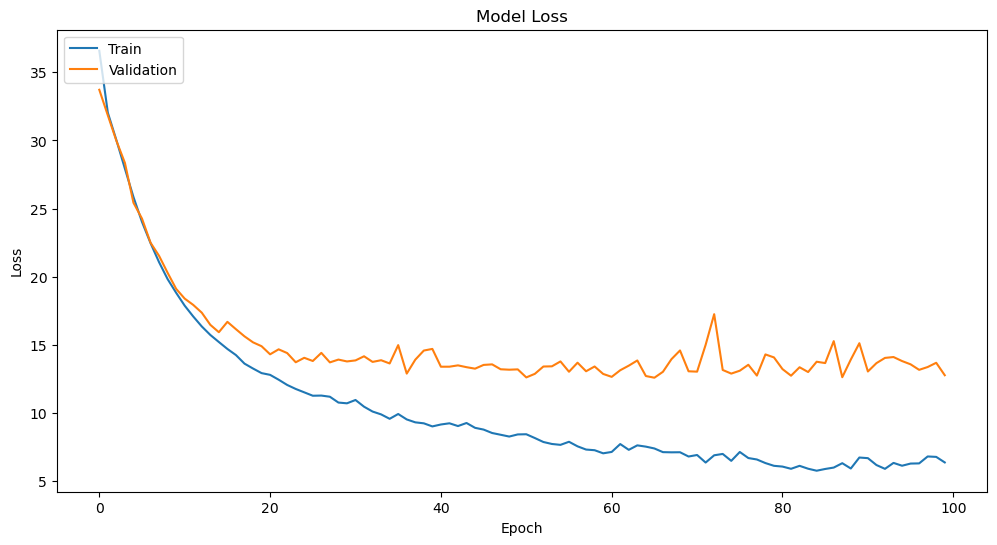

In [6]:
# Call the plot_training_history function
def plot_training_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    # A dictionary containing the recorded values of different metrics during training
    plt.plot(history.history['loss'])
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_training_history(history)


In [ ]:
##prediction

In [7]:
b = r'C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\test\tru\de01_027.tru'
racine_gt=r"C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\test\tru"

def get_Word(name):
    file_name = name.split("\\")[-1].split(".")[0]
    path_gt = racine_gt + "\\" + file_name + ".tru"
    load_profile = open(path_gt, "r")
    label = load_profile.read().splitlines()[6]
    word = label.split(":")[-3].split(";")[0].split("|")[:-1]
    return word
get_Word(b) 

['kaB', 'raE', 'baB', 'saE']

In [ ]:
#decodage 1

In [8]:
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K

def preprocess_image(image_path, img_size=(100, 300)):
    img = cv2.imread(image_path, 0)
    img = cv2.resize(img, (img_size[1], img_size[0]), interpolation=cv2.INTER_LANCZOS4)
    img = cv2.threshold(img, 255 // 2, 255, cv2.THRESH_BINARY)[1]
    img = cv2.bitwise_not(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def decode_prediction(pred, chars):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    decoded = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    decoded_texts = []
    for d in decoded:
        decoded_texts.append(''.join([chars[char] for char in d.numpy() if char != -1]))
    return decoded_texts

# Create the inference model
input_data = Input(name='the_input', shape=(img_h, img_w), dtype='float32')
y_pred = model.get_layer('softmax').output

inference_model = Model(inputs=model.input[0], outputs=y_pred)

# Example usage
image_path = r'C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\test\tif\de01_027.tif'
preprocessed_image = preprocess_image(image_path)
prediction = inference_model.predict(preprocessed_image)

decoded_texts = decode_prediction(prediction, inve_classes)
real=''.join(get_Word(b))
print('real Text:', real)
print('Predicted Text:', decoded_texts[0])

1/1 [==============================] - 3s 3s/step
real Text: kaBraEbaBsaE
Predicted Text: kaBraEbaBsaE


In [61]:
y_pred

<KerasTensor: shape=(None, 75, 125) dtype=float32 (created by layer 'softmax')>

In [ ]:
#decodage 2 

In [9]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Prepare the input
def prepare_input_single(image_path, img_size=(300, 100)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, img_size)
    image = cv2.threshold(image, 255 // 2, 255, cv2.THRESH_BINARY)[1]
    image = cv2.bitwise_not(image)
    image = np.expand_dims(image, axis=0)  
    
    input_length = np.array([[img_size[1] // 4]])  
    dummy_labels = np.zeros((1, 17))
    dummy_label_length = np.array([[17]])  
    
    return image, dummy_labels, input_length, dummy_label_length

def predict_single_image(model, image_path, img_size=(300, 100)):
    image, dummy_labels, input_length, dummy_label_length = prepare_input_single(image_path, img_size)
    inputs = {
        'the_input': image,
        'the_labels': dummy_labels,
        'input_length': input_length,
        'label_length': dummy_label_length
    }
    
    predictions = model.predict(inputs)
    
    
    return predictions, input_length

image_path = r'C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\ttrain\tif\am15_067.tif'


predictions, input_length = predict_single_image(model, image_path)


def decode_ctc_output(preds, char_map):
    pred_index = []
    for p in preds:
        index = np.argmax(p)
        char = char_map.get(index, 'b')  # Get the character or '' if not found
        if char != '':
            pred_index.append(char)
    return pred_index

decoded_indices = decode_ctc_output(predictions[1][0], inve_classes)
print(decoded_indices)

1/1 [==============================] - 4s 4s/step
['b', 'b', 'maB', 'b', 'b', 'b', 'b', 'aaE', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'jaB', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'teA', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']


In [10]:
# Function to decode predictions using beam search
def decode_predictions(predictions, inv_classes, beam_width=10):
    y_pred = predictions[1]  
    decoded = K.get_value(K.ctc_decode(y_pred,
                                       input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1],
                                       greedy=False,
                                       beam_width=beam_width)[0][0])
    decoded_words = []
    for d in decoded:
        decoded_word = num_to_label(d, inv_classes)
        
    return decoded_word
def num_to_label(num_arr, inv_classes):
    return [inv_classes[num] for num in num_arr if num != -1]

decode_predictions(predictions,inve_classes)

['maB', 'aaE', 'jaB', 'waE', 'teA']

In [11]:
import os
def get_all_files_in_directory(directory_path):
    # Get all files in the directory and its subdirectories
    all_files = []
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files
tif=r'C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\test\tif'
names_tif =get_all_files_in_directory(tif)

In [12]:
names_tif

['C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_002.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_005.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_008.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_009.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_015.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_016.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_017.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnenit_v2.0p1e\\data\\test\\tif\\de01_018.tif',
 'C:\\Users\\Pro\\Desktop\\OCR\\ifnenit_database\\ifnenit_v2.0p1e\\ifnen

In [13]:
racine_gt=r"C:\Users\Pro\Desktop\OCR\ifnenit_database\ifnenit_v2.0p1e\ifnenit_v2.0p1e\data\test\tru"

def get_Word(name):
    file_name = name.split("\\")[-1].split(".")[0]
    path_gt = racine_gt + "\\" + file_name + ".tru"
    load_profile = open(path_gt, "r")
    label = load_profile.read().splitlines()[6]
    word = label.split(":")[-3].split(";")[0].split("|")[:-1]
    return word

true_words=[]
predicted_words=[]
for i in  names_tif :
            true_text=get_Word(i)
            true_text=''.join(true_text)
            true_words.append(true_text)
            
            predictions, input_length = predict_single_image(model, i)
            decoded_text= decode_predictions(predictions, inve_classes, beam_width=10)
            decoded_text=''.join(decoded_text)
            predicted_words.append(decoded_text)
            print(f"True Text: {true_text}  ---  predicted text :{decoded_text} ")

1/1 [==============================] - 0s 112ms/step
True Text: aeAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA  ---  predicted text :aeAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA 
1/1 [==============================] - 0s 120ms/step
True Text: aeAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA  ---  predicted text :aeAwaAtaByaMkeEaaAlaBdaEyaBdaEteA 
1/1 [==============================] - 0s 127ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA6A 
1/1 [==============================] - 0s 121ms/step
True Text: aaAlaBshMkaMraEaaAnaByaMteE  ---  predicted text :aaAlaBshMraEaaAshBteE 
1/1 [==============================] - 0s 113ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 122ms/step
True Text: maBraEfaBkaEaaAlaBfaMraEyaBwaE  ---  predicted text :maBraEfaBkaEaaAlaBfaMraEyaBwaE 
1/1 [==============================] - 0s 124ms/step
True Text: saBbaMyaMhaE  ---  predicted text :sa

1/1 [==============================] - 0s 115ms/step
True Text: baBnaMzaEraAtaA  ---  predicted text :baBwaEtaA 
1/1 [==============================] - 0s 120ms/step
True Text: aeAmaAaaAlaBayMzaMaaEmaA  ---  predicted text :aeAmaAaaAlaBayMzaMaaEmaA 
1/1 [==============================] - 0s 116ms/step
True Text: seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA  ---  predicted text :seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA 
1/1 [==============================] - 0s 123ms/step
True Text: maBtaMlaMwaEyaAthBaaElaBjaMteE  ---  predicted text :maBaaEaaAlaBwaEteE 
1/1 [==============================] - 0s 131ms/step
True Text: aaAlaBnaMaaEdeBwaEraA  ---  predicted text :aaAlaBnaMaaEdeBwaEraA 
1/1 [==============================] - 0s 121ms/step
True Text: taBtoMaaEwaAyaBnaE  ---  predicted text :kaBnaMraEbaBdaA 
1/1 [==============================] - 0s 144ms/step
True Text: waAaaAdaAyaAaaAlaBghMaaEraA  ---  predicted text :waAaaAdaAyaAaaAmaMbaMraA 
1/1 [==============================] - 0s 127ms/step
True T

1/1 [==============================] - 0s 119ms/step
True Text: daAjaBbaMteE  ---  predicted text :baBjaMteE 
1/1 [==============================] - 0s 115ms/step
True Text: baBalMraEthBaaElaMthByaMnaE  ---  predicted text :baBalMraEthByaMnaE 
1/1 [==============================] - 0s 122ms/step
True Text: shBwaEaaAtoA  ---  predicted text :laBaaEtoA 
1/1 [==============================] - 0s 117ms/step
True Text: keBmaMbaMwaEtoA  ---  predicted text :keBmaMbaMwaEtoA 
1/1 [==============================] - 0s 121ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 122ms/step
True Text: keBseMraEeeA  ---  predicted text :haBmaMaaEteA 
1/1 [==============================] - 0s 122ms/step
True Text: naBaaEbaBlaEthBaaEmaBraE  ---  predicted text :naBaaEayBaaEmaBraE 
1/1 [==============================] - 0s 113ms/step
True Text: taBwaEnaBseEbaBaaEbaAbaBnaMaaEtaA  ---  predicted text :taBwaEnaBseEbaAaaAseBnaMaa

1/1 [==============================] - 0s 123ms/step
True Text: aaAlaBnaMaaEdeBwaEraA  ---  predicted text :aaAlaBnaMaaEraE 
1/1 [==============================] - 0s 120ms/step
True Text: aeAwaAaaElaBdaAheBaaElaMlaA  ---  predicted text :aeAwaAaaElaBdaAaaAlaBshMaaEaaAhhA 
1/1 [==============================] - 0s 122ms/step
True Text: seByaMdaEyaAayBaaEmaBraE  ---  predicted text :maBnaMzaEthBaaEraE 
1/1 [==============================] - 0s 122ms/step
True Text: aaAlaBkhMtaMmaMyaMnaE  ---  predicted text :aaAlaBaaAyaBnaE 
1/1 [==============================] - 0s 119ms/step
True Text: haByaEaaAlaBsaMaaElaMhaA  ---  predicted text :haByaEaaAlaBsaMaaElaMhaA 
1/1 [==============================] - 0s 119ms/step
True Text: aaAlaBfaMhaMsaE  ---  predicted text :aaAlaBfaMhaMsaE 
1/1 [==============================] - 0s 115ms/step
True Text: shBtaMaaEwaAteAsaBhaMraEaaAwaAyaA  ---  predicted text :shBtaMaaEwaAteAsaBhaMraEaaAwaAyaA 
1/1 [==============================] - 0s 126ms/step
True T

1/1 [==============================] - 0s 112ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEjaA 
1/1 [==============================] - 0s 106ms/step
True Text: haByaEaaAahElaBnaBtoMaaElaMkaBteE  ---  predicted text :haByaEaaAlaBmaMyaMteE 
1/1 [==============================] - 0s 109ms/step
True Text: jaBraEjaByaMseE  ---  predicted text :jaBwaEyaMsaE 
1/1 [==============================] - 0s 109ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 110ms/step
True Text: ayBkaMaaEraAbaA  ---  predicted text :maBaaEraA 
1/1 [==============================] - 0s 115ms/step
True Text: daAwaAzaA  ---  predicted text :haBfaMwaE 
1/1 [==============================] - 0s 107ms/step
True Text: aaAmaMlaBhaMaaEraAzaAteA8A1A  ---  predicted text :aaAmaMlaBhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 123ms/step
True Text: saBfaMaaEkaBseEaaAjaMlaBdaEyaBdaEteA  

1/1 [==============================] - 0s 114ms/step
True Text: raAaeAseAaaAlaBdhEraAaaAayA  ---  predicted text :raAseAaaAlaBayA 
1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBghMaaEshByaMnaE  ---  predicted text :aaAlaBayMkeMaaEraAyaBnaE 
1/1 [==============================] - 0s 106ms/step
True Text: maBnaMzaElaAaaAlaBmaMhaMtoMteE  ---  predicted text :taBaaEraAyaBaaEteE 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBkaMlaMayMteEaaAlaBkeMbaMraEeeA  ---  predicted text :aaAlaBkaMlaMayMteEaaAlaBbaMraEeeA 
1/1 [==============================] - 0s 106ms/step
True Text: kaBsaMraEdaAbaBaaEbaA  ---  predicted text :kaBbaMteE 
1/1 [==============================] - 0s 120ms/step
True Text: aaAlaBraEdeBaaEayA  ---  predicted text :saBbaMhaE 
1/1 [==============================] - 0s 135ms/step
True Text: seByaMdaEyaAahAbaBraEaaAheByaMmaEaaAlaBzaEheBaaEraA  ---  predicted text :raAbaBaaEayEseByaMzaBaaEraE 
1/1 [==============================] -

1/1 [==============================] - 0s 119ms/step
True Text: aaAlaBkaMlaMayMteEaaAlaBsaMghMraEeeA  ---  predicted text :aaAlaBkaMlaMayMteEaaAlaBbaMraEeeA 
1/1 [==============================] - 0s 115ms/step
True Text: saBdaEkaBteE  ---  predicted text :baBraEteE 
1/1 [==============================] - 0s 118ms/step
True Text: baBalMraEaaAlaBdaEwaAlaBteE  ---  predicted text :waAkaBraEdaAaaAlaBwaEaaAteE 
1/1 [==============================] - 0s 120ms/step
True Text: maBnaMzaElaAaaAlaBhaMbaMyaMbaE  ---  predicted text :maBnaMzaElaAaaAlaByaMkaE 
1/1 [==============================] - 0s 109ms/step
True Text: aaAlaBzaEheBraEaaAhhAaaAlaBhaMbaMyaMbaE  ---  predicted text :aaAlaBzaEheBhhAaaAlaBhaMbaMyaMbaE 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBraEhaBaaEyaBaaEtaA  ---  predicted text :aaAlaBraEdaAaaEdaA 
1/1 [==============================] - 0s 115ms/step
True Text: baBwaEthBdaEyaA  ---  predicted text :baBwaEnaByaA 
1/1 [==============================] -

1/1 [==============================] - 0s 120ms/step
True Text: haByaEbaBwaEsaBfaMaaEraAteA  ---  predicted text :haByaElaBbaMaaEsaE 
1/1 [==============================] - 0s 111ms/step
True Text: jaBbaMlaEaaAlaBraEsaBaaEsaA  ---  predicted text :jaByaMnaEyaBdeA 
1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBdaEkhBaaEnaByaMteE  ---  predicted text :aaAlaBseMaaEyaBteE 
1/1 [==============================] - 0s 114ms/step
True Text: kaBsaMraEdaAbaBaaEbaA  ---  predicted text :maBraEseBteE 
1/1 [==============================] - 0s 111ms/step
True Text: raAyaBaaEdeAbaBwaEheBaaElaMlaA  ---  predicted text :baBraEfaBaaAlaBraEyaBraA 
1/1 [==============================] - 0s 116ms/step
True Text: taBaaElaMlaBtaE  ---  predicted text :taBaaElaMbaBtaE 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBraEdaAyaBfaEaaAlaBmaMhaMtoMteE  ---  predicted text :aaAlaBraEnaAaaAlaBlaMhhA 
1/1 [==============================] - 0s 115ms/step
True Text: aeAwaAa

1/1 [==============================] - 0s 119ms/step
True Text: amAlaBayMwaEaaAbaBdaE  ---  predicted text :amAtaBseMdaEeeA 
1/1 [==============================] - 0s 114ms/step
True Text: haBaaEmaBteEamAlaBjaMraEyaBdaE  ---  predicted text :baMayMteEaaAlaBkeMraEeeA 
1/1 [==============================] - 0s 107ms/step
True Text: seByaMdaEyaAaaAbaBraEaaAheByaMmaEamAlaBzaEheBaaEraA  ---  predicted text :seByaMdaEyaAbaBraE 
1/1 [==============================] - 0s 114ms/step
True Text: maBaaEraAthA  ---  predicted text :heBaaEyaB6A 
1/1 [==============================] - 0s 105ms/step
True Text: haBaaEmaBteEaaAlaBjaMraEyaBdaE  ---  predicted text :ayMteEaaAlaBkeMbaMraEeeA 
1/1 [==============================] - 0s 117ms/step
True Text: baBlaMyaMaaEnaBteE  ---  predicted text :baBaaElaMteE 
1/1 [==============================] - 0s 109ms/step
True Text: maBtoMmaMaaEtoBteE  ---  predicted text :maBraEkeByaBteE 
1/1 [==============================] - 0s 113ms/step
True Text: aaAlaBfaMaaEya

1/1 [==============================] - 0s 113ms/step
True Text: haBlaMkaEaaAjaMlaBmaMlaE  ---  predicted text :ghBaaEraAaaAlaBmaMlaMlaE 
1/1 [==============================] - 0s 110ms/step
True Text: baBwaEayBthMmaMaaEnaA  ---  predicted text :baBwaEayBmaMaaEnaA 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBfaMaaEyaBdeE  ---  predicted text :aaAlaBfaMaaEyaBdeE 
1/1 [==============================] - 0s 110ms/step
True Text: baBlaMkhMyaMraE  ---  predicted text :baBaaEraE 
1/1 [==============================] - 0s 110ms/step
True Text: maBseMjaMdaEayByaMseMeeE  ---  predicted text :maBseMjaMdaEayByaMeeE 
1/1 [==============================] - 0s 103ms/step
True Text: aaAlaBmaMnaMaaEraA2A  ---  predicted text :aaAlaBmaMhaMaaEraAteA 
1/1 [==============================] - 0s 112ms/step
True Text: naBkeMraEyaBfaE  ---  predicted text :maBraEfaE 
1/1 [==============================] - 0s 100ms/step
True Text: toBbaMlaMbaMteE  ---  predicted text :kaBaaElaMteE 
1/1 

1/1 [==============================] - 0s 105ms/step
True Text: zaAlaBbaMteE  ---  predicted text :baBaaEteE 
1/1 [==============================] - 0s 106ms/step
True Text: daAkaBaaEshA  ---  predicted text :naBaaElaA 
1/1 [==============================] - 0s 100ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAmaMlaBmaMhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 99ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 103ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 109ms/step
True Text: aaAlaBdhEraAyaBayMaaEtaA  ---  predicted text :aaAlaBdhEyaBaaEtaA 
1/1 [==============================] - 0s 103ms/step
True Text: naByaMaaEnaBwaE  ---  predicted text :baBwaEraA 
1/1 [==============================] - 0s 105ms/step
True T

1/1 [==============================] - 0s 111ms/step
True Text: aaAmaMlaBnaMzaEheA6A  ---  predicted text :aaAlaBraEheA6A 
1/1 [==============================] - 0s 103ms/step
True Text: ghBaaEraAaaAlaBmaMlaMhaE  ---  predicted text :ghBaaEraAaaAlaBlaMhaE 
1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBfaMhaMsaE  ---  predicted text :aaAlaBfaMhaMsaE 
1/1 [==============================] - 0s 103ms/step
True Text: heBdhEyaBlaE  ---  predicted text :keBseMaaEteE 
1/1 [==============================] - 0s 105ms/step
True Text: haBlaMkaEaaAlaBwaEaaAdaAyaA  ---  predicted text :haBlaMkaEaaAlaBwaEaaAyaA 
1/1 [==============================] - 0s 103ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] - 0s 106ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] 

True Text: maBraEkeBzaEshBaaEkeBraE  ---  predicted text :maByaMdaEyaAkeBaaEraE 
1/1 [==============================] - 0s 106ms/step
True Text: maBbaMraEwaAkeBteE  ---  predicted text :seBdaEwaAyaBteE 
1/1 [==============================] - 0s 98ms/step
True Text: kaBsaMyaMteEseBwaEseBteE  ---  predicted text :aeAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA 
1/1 [==============================] - 0s 103ms/step
True Text: aeAwaAtaByaMkeE  ---  predicted text :aaAwaAtaByaMkeE 
1/1 [==============================] - 0s 106ms/step
True Text: kaBraEbaBsaE  ---  predicted text :shBaaEbaBsaE 
1/1 [==============================] - 0s 105ms/step
True Text: maBaaEraAthA  ---  predicted text :maBaaEraAthA 
1/1 [==============================] - 0s 107ms/step
True Text: ayByaMnaEtaBwaEnaByaMnaE  ---  predicted text :ayByaMnaEyaBbaMkaE 
1/1 [==============================] - 0s 105ms/step
True Text: aaAlaBzaEraAyaBbaMteE  ---  predicted text :aaAlaBraEyaBteE 
1/1 [==============================] - 0s 109ms/

1/1 [==============================] - 0s 106ms/step
True Text: kaBraEyaBbaMyaMsaE  ---  predicted text :kaBraEyaBbaMyaMsaE 
1/1 [==============================] - 0s 111ms/step
True Text: maBraEfaBkaEaaAlaBfaMraEyaBwaE  ---  predicted text :maBraEfaBkaEaaAlaBfaMraEyaBwaE 
1/1 [==============================] - 0s 111ms/step
True Text: keBseMraEeeAaaAlaBayMlaMyaMaaE  ---  predicted text :keBseMraEeeAaaAlaBayMlaMyaMaaE 
1/1 [==============================] - 0s 101ms/step
True Text: aaAlaBkhMlaMyaMjaE  ---  predicted text :aaAlaBkhMlaMyaMjaE 
1/1 [==============================] - 0s 107ms/step
True Text: haByaEaaAlaBsaMaaElaMhaA  ---  predicted text :haByaEaaAlaBsaMaaElaMhaA 
1/1 [==============================] - 0s 106ms/step
True Text: haByaEaaAaaElaBmaBlaE  ---  predicted text :haByaEaaAlaBaaElaMhhA 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBkeMaaEfaAaaAlaBghMraEbaByaE  ---  predicted text :aaAlaBkaMlaMayMteEaaAlaBkeMghMraEyaE 
1/1 [=====================

1/1 [==============================] - 0s 112ms/step
True Text: aeAwaAtaByaMkeE  ---  predicted text :aeAwaAtaByaMkeE 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBnaMwaEaaAyaBlaE  ---  predicted text :aaAlaBtoMwaEyaByaMyaE 
1/1 [==============================] - 0s 102ms/step
True Text: haByaEaaAlaBmaMheMraEjaBaaEnaA  ---  predicted text :seByaMdaEyaAbaBraEaaAdaA 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBbaMwaEayBteE  ---  predicted text :aaAlaBbaMraEteE 
1/1 [==============================] - 0s 104ms/step
True Text: baBwaEjaBlaMyaMdaEteA  ---  predicted text :baBwaEthByaMnaE 
1/1 [==============================] - 0s 106ms/step
True Text: kaBraEbaBsaE  ---  predicted text :kaBraEseBsaE 
1/1 [==============================] - 0s 112ms/step
True Text: keBseMraEeeAaaAlaBayMlaMyaMaaE  ---  predicted text :keBseMraEeeAaaAlaBayMyaMaaE 
1/1 [==============================] - 0s 107ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMra

1/1 [==============================] - 0s 104ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] - 0s 103ms/step
True Text: maBraEseBeeEaaAlaBsaMfaMsaMaaEfaA  ---  predicted text :seBraEnaBbaAaaAlaBaaEyaBteE 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBkaMyaMraEwaAaaAnaAaaAjaMlaBnaMwaEbaByaMteE  ---  predicted text :aaAlaBzaEheBaaAlaBjaMheMwaEraAyaBdaEteA 
1/1 [==============================] - 0s 105ms/step
True Text: aaAhaMlaBbaMyaMbaMyaMteE  ---  predicted text :aaAlaBmaMraEteE 
1/1 [==============================] - 0s 104ms/step
True Text: khBnaMkaMteEaaAhaMlaBjaMaaEjaA  ---  predicted text :faBnaMaaEteEseBaaEjaA 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBmaMzaEaaAwaAghBteE  ---  predicted text :aaAlaBmaMzaEaaAwaAteE 
1/1 [==============================] - 0s 110ms/step
True Text: kaBbaMaaElaMtoA  ---  predicted text :-baM

1/1 [==============================] - 0s 109ms/step
True Text: baBnaMzaEraAtaAbaBaaEbaAmaBaaEtoBraE  ---  predicted text :maBnaMzaElaAraAaaAlaBraEyaBaaEraE 
1/1 [==============================] - 0s 109ms/step
True Text: haByaEaaAlaBtaMhaMraEyaBraE  ---  predicted text :haByaEaaAlaBhaMwaEraE 
1/1 [==============================] - 0s 108ms/step
True Text: jaBwaEmaByaMnaE  ---  predicted text :baBwaEayByaMnaE 
1/1 [==============================] - 0s 117ms/step
True Text: toBraEwaAdaAseBwaEseBteE  ---  predicted text :toBraEwaAdaAseBwaEdaAseBteE 
1/1 [==============================] - 0s 118ms/step
True Text: aaAlaBmaMnaMzaEheA6A  ---  predicted text :aaAlaBmaMnaMzaEheA6A 
1/1 [==============================] - 0s 109ms/step
True Text: maBthMlaMyaMnaE  ---  predicted text :shBmaMaaEyaMnaE 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBmaMnaMzaEheA6A  ---  predicted text :aaAlaBmaMnaMzaEheA6A 
1/1 [==============================] - 0s 113ms/step
True Text: aaAla

1/1 [==============================] - 0s 109ms/step
True Text: seByaMdaEyaAkhBlaMyaMfaMteE  ---  predicted text :seByaMdaEyaAmaBzaEteE 
1/1 [==============================] - 0s 117ms/step
True Text: haByaMdaEraAteA  ---  predicted text :haBzaEraAteA 
1/1 [==============================] - 0s 104ms/step
True Text: dhAraAaaAayAbaBnaEzaAyaBaaEdaA  ---  predicted text :dhAraAaaAayAbaBnaEwaEyaBhhA 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBkhMlaMyaMjaE  ---  predicted text :aaAlaBayMaaEyaMjaE 
1/1 [==============================] - 0s 104ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAmaMlaBmaMhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 108ms/step
True Text: baBnaMyaEghByaMlaMwaEfaA  ---  predicted text :baBnaMyaEayByaMfaA 
1/1 [==============================] - 0s 109ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [=========================

1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBghMraEaaAbaBtoE  ---  predicted text :aaAlaBghMraEaaAbaBtoE 
1/1 [==============================] - 0s 104ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 124ms/step
True Text: aaAlaBraEdaAyaBfaE  ---  predicted text :aaAlaBraEyaBfaE 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBraEyaBaaEdeA  ---  predicted text :aaAlaBraEyaBaaEdeA 
1/1 [==============================] - 0s 100ms/step
True Text: maBaaEraAthA  ---  predicted text :maBaaEraAthA 
1/1 [==============================] - 0s 109ms/step
True Text: aaAlaBshMhaMyaMmaMaaEtaA  ---  predicted text :aaAlaBshMyaMaaEseBaaEtaA 
1/1 [==============================] - 0s 111ms/step
True Text: baBwaEdhAraA  ---  predicted text :baBwaEdhAraA 
1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBseMfaMyaMnaMteE  ---  predicted text :aaAlaB

1/1 [==============================] - 0s 117ms/step
True Text: aeAwaAaaElaBdaAaaAlaBshMaaEmaBkhE  ---  predicted text :aeAwaAaaElaBdaAaaAlaBshMaaEmaBkhE 
1/1 [==============================] - 0s 121ms/step
True Text: shBmaMaaEkhA  ---  predicted text :shBmaMaaEkhA 
1/1 [==============================] - 0s 119ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA9A 
1/1 [==============================] - 0s 121ms/step
True Text: baBwaEzaAkaBaaEmaA  ---  predicted text :baBwaEteE 
1/1 [==============================] - 0s 116ms/step
True Text: baBnaMzaEraAtaAbaBaaEbaAmaBaaEtoBraE  ---  predicted text :baBaaEraAseByaMaaEraE 
1/1 [==============================] - 0s 108ms/step
True Text: taBwaEnaBseEaaAlaBshMaaEbaByaE  ---  predicted text :taBwaEnaBteEaaAlaBraEaaAbaByaE 
1/1 [==============================] - 0s 126ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBaaEteEaaAbaBraA 
1/1 [==============================] - 0s 120ms/step
True Tex

1/1 [==============================] - 0s 104ms/step
True Text: baBalMraEthBaaElaMthByaMnaE  ---  predicted text :baBalMraEtaByaMnaE 
1/1 [==============================] - 0s 100ms/step
True Text: seBmaMnaMjaMteE  ---  predicted text :seBnaMjaMteE 
1/1 [==============================] - 0s 103ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 103ms/step
True Text: zaAyaBtaMwaEnaBteE  ---  predicted text :raAbaMteE 
1/1 [==============================] - 0s 115ms/step
True Text: aaAlaBmaMseMayMdaEyaBnaE  ---  predicted text :aaAlaBayMaaEyaBaaEbaE 
1/1 [==============================] - 0s 103ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] - 0s 109ms/step
True Text: baBalMraEmaBshMaaEraAkaBbaMteE  ---  predicted text :baBalMraEayByaMteE 
1/1 [==============================] - 0s 102ms/step
True T

1/1 [==============================] - 0s 101ms/step
True Text: taBtoMaaEwaAyaBnaE  ---  predicted text :aaAlaBaaEjaBaaEyaA 
1/1 [==============================] - 0s 104ms/step
True Text: kaBsaMraEaaAlaBmaMraEaaAbaBtoMyaMnaE  ---  predicted text :taBlaEaaAlaBkaMraEaaAyaA 
1/1 [==============================] - 0s 101ms/step
True Text: aeAwaAtaByaMkeEaaAlaBjaMdaEyaBdaEteA  ---  predicted text :aeAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA 
1/1 [==============================] - 0s 108ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 101ms/step
True Text: ayBmaMyaMraEteAaaAlaBfaMhaMwaElaA  ---  predicted text :ayByaMnaEaaAlaBmaMaaEwaE 
1/1 [==============================] - 0s 108ms/step
True Text: aaAlaBfaMaaEyaBdeE  ---  predicted text :aaAlaBfaMaaEyaBdeE 
1/1 [==============================] - 0s 107ms/step
True Text: aaAkhMlaBzaMraEaaAhhA  ---  predicted text :aaAkhMlaBzaMraEaaAhhA 
1/1 [=============

1/1 [==============================] - 0s 116ms/step
True Text: ghBnaMaaEdaAteA  ---  predicted text :ghBnaMzaEraAnaA 
1/1 [==============================] - 0s 115ms/step
True Text: aaAmaMlaBhaMaaEraAzaAteA8A1A  ---  predicted text :aaAmaMlaBaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 115ms/step
True Text: aaAlaBayMkeMaaEraAyaBtaE  ---  predicted text :aaAlaBayMaaEwaAteE 
1/1 [==============================] - 0s 107ms/step
True Text: aaAhaMmaMlaBaaEraAzaAteA8A1A  ---  predicted text :aaAmaMlaBhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 102ms/step
True Text: baBraEjaAaaAlaBkeMraEmaBteE  ---  predicted text :maBraEaaAlaBteE 
1/1 [==============================] - 0s 112ms/step
True Text: shBtaMaaEwaAteAsaBhaMraEaaAwaAyaA  ---  predicted text :aaAlaBkeMaaEteEbaBhaMraEwaAyaA 
1/1 [==============================] - 0s 104ms/step
True Text: taBaaElaMbaBtaE  ---  predicted text :maBaaEraAthA 
1/1 [==============================] - 0s 112ms/step
True Text: 

1/1 [==============================] - 0s 105ms/step
True Text: aaAlaBkaMlaMayMteEaaAlaBsaMghMraEeeA  ---  predicted text :aaAlaBkaMlaMayMteEaaAlaBkeMbaMraEeeA 
1/1 [==============================] - 0s 113ms/step
True Text: naBkeMraEyaBfaE  ---  predicted text :kaBraEbaBsaE 
1/1 [==============================] - 0s 105ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 117ms/step
True Text: heBdhEyaBlaE  ---  predicted text :heBdhEyaBlaE 
1/1 [==============================] - 0s 108ms/step
True Text: haByaEaaAlaBsaMaaElaMhaA  ---  predicted text :haByaEaaAlaBsaMaaElaMhaA 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBkhMlaMyaMjaE  ---  predicted text :aaAlaBkhMlaMyaMjaE 
1/1 [==============================] - 0s 111ms/step
True Text: aaAlaBkaMlaMayMteE  ---  predicted text :aaAlaBkaMtaMteE 
1/1 [==============================] - 0s 117ms/step
True Text: seBbaMayMteEamAbaBaaEraA 

1/1 [==============================] - 0s 110ms/step
True Text: keBseMraEeeAaaAlaBayMlaMyaMaaE  ---  predicted text :keBseMraEeeAaaAlaBayMlaMaaE 
1/1 [==============================] - 0s 124ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAmaMlaBnaMzaEheA9A 
1/1 [==============================] - 0s 104ms/step
True Text: aaAlaBfaMhaMsaE  ---  predicted text :aaAlaBfaMhaMsaE 
1/1 [==============================] - 0s 101ms/step
True Text: aaAlaBkhMraEshBfaE  ---  predicted text :aaAlaBkhMraEaaAshBfaE 
1/1 [==============================] - 0s 109ms/step
True Text: haByaEaaAlaBsaMaaElaMhaA  ---  predicted text :haByaEaaAlaBsaMaaElaMhaA 
1/1 [==============================] - 0s 111ms/step
True Text: dhAheByaMbaMteE  ---  predicted text :dhAheByaMbaMteE 
1/1 [==============================] - 0s 103ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] - 0s 104ms/step
Tr

1/1 [==============================] - 0s 104ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 105ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 102ms/step
True Text: raAaeAseAaaAlaBdhEraAaaAayA  ---  predicted text :aaAlaBaaAlaE 
1/1 [==============================] - 0s 107ms/step
True Text: zaAaaAwaAyaBteEaaAlaBayMaaEnaBseE  ---  predicted text :aaAfaBaaAlaBshMaaEhhA 
1/1 [==============================] - 0s 98ms/step
True Text: aaAlaBkeMnaMaaEyaBseE  ---  predicted text :aaAlaBfaMaaEyaBdeE 
1/1 [==============================] - 0s 111ms/step
True Text: taBwaEnaBseEaaAlaBshMaaEbaByaE  ---  predicted text :taBwaEnaBseEaaAlaBshMaaEbaByaE 
1/1 [==============================] - 0s 122ms/step
True Text: seByaMdaEyaAayBthMmaMaaEnaA  ---  predicted text :seBwaEnaA 
1/1 [==============================] - 0s 110m

1/1 [==============================] - 0s 116ms/step
True Text: baBalMraEayBlaMyaEbaBnaEkhBlaMyaMfaMheE  ---  predicted text :baBalMraEayBlaMyaEbaBnaEkhBlaMyaMfaMteE 
1/1 [==============================] - 0s 128ms/step
True Text: seByaMdaEyaAnaBsaMraE  ---  predicted text :seBdaEyaAthBlaE 
1/1 [==============================] - 0s 116ms/step
True Text: taBwaEnaBseEbaBaaEbaAaaAkhMlaBdeMraEaaAhhA  ---  predicted text :naBmaMraEnaBaaE-yaMteE0A2AmaBaaEraAseA 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBfaMjaMteE  ---  predicted text :aaAlaBfaMbaMteE 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBdaEkhBaaEnaByaMteE  ---  predicted text :aaAlaBaaEyaBteE 
1/1 [==============================] - 0s 104ms/step
True Text: haByaEaaAlaBtaMhaMraEyaBraE  ---  predicted text :taBlaEaaAlaBzaEyaBnaE 
1/1 [==============================] - 0s 119ms/step
True Text: aaAlaBheMwaEaaAraAyaBteE  ---  predicted text :aaAlaBzaEaaAyaBtoE 
1/1 [===================

1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBmaMayMmaMwaEraAteA  ---  predicted text :aaAlaBmaMsaMwaEraAteA 
1/1 [==============================] - 0s 122ms/step
True Text: aaAlaBkeMraEyaBbaEmaBhaMtoMteE  ---  predicted text :aaAlaBseMaaEayBnaE 
1/1 [==============================] - 0s 105ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 122ms/step
True Text: daAwaAaaAraAaaAlaBlaMwaEaaAtaBheE  ---  predicted text :haBlaEaaAlaBghMzaEdaAraA 
1/1 [==============================] - 0s 110ms/step
True Text: raAaeAseAaaAlaBdhEraAaaAayA  ---  predicted text :raAseAaaAlaBaaAayA 
1/1 [==============================] - 0s 104ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAhaMmaMlaBhaMaaEraAzaAteA 
1/1 [==============================] - 0s 128ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAzaAteA8

1/1 [==============================] - 0s 123ms/step
True Text: raAyaBaaEdeAbaBwaEheBaaElaMlaA  ---  predicted text :raAaaEbaBwaEheBlaA 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBmaMseMaaEayByaMdaE  ---  predicted text :aaAlaBseMaaEdaE 
1/1 [==============================] - 0s 120ms/step
True Text: taBlaEaaAlaBghMzaEaaElaBnaA  ---  predicted text :taBlaEaaAlaBghMzaEaaElaBnaA 
1/1 [==============================] - 0s 120ms/step
True Text: haByaEaeAwaAaaElaBdaAbaBaaElaBheMaaEdaAyaA  ---  predicted text :taBwaEaaAlaBheMaaEseA 
1/1 [==============================] - 0s 104ms/step
True Text: aaAmaMlaBhaMaaEraAzaAteA8A1A  ---  predicted text :aaAmaMlaBhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 109ms/step
True Text: aaAlaBraEhaByaMshE  ---  predicted text :aaAlaBraEhaByaMshE 
1/1 [==============================] - 0s 108ms/step
True Text: aaAlaBkaMraEyaBteE  ---  predicted text :aaAlaBnaMraEteE 
1/1 [==============================] - 0s 104ms/

1/1 [==============================] - 0s 104ms/step
True Text: maBnaMzaElaAbaBaaElaBwaEaaAayBraE  ---  predicted text :maBnaMzaElaAbaBwaElaE 
1/1 [==============================] - 0s 101ms/step
True Text: aaAlaBkhMlaMyaMjaE  ---  predicted text :aaAlaBkhMlaMyaMjaE 
1/1 [==============================] - 0s 108ms/step
True Text: maBthMaaEnaByaMteE  ---  predicted text :haBmaMaaEseBnaBteE 
1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAteA 
1/1 [==============================] - 0s 104ms/step
True Text: aeAwaAtaByaMkeE  ---  predicted text :aeAwaAtaBkeE 
1/1 [==============================] - 0s 143ms/step
True Text: aaAlaBnaMwaEaaAyaBlaE  ---  predicted text :aaAlaBseMaaEaaAyaBlaE 
1/1 [==============================] - 0s 106ms/step
True Text: seByaMdaEyaAmaBkhMlaMwaEfaA  ---  predicted text :seByaMdaEyaAmaBaaEbaBtaE 
1/1 [==============================] - 0s 110ms/step
True Text: shBtaMaaEwaAteAsaB

1/1 [==============================] - 0s 111ms/step
True Text: baBraEjaAaaAmaMlaBzaMyaMlaMteE  ---  predicted text :baByaMlaMyaMteE 
1/1 [==============================] - 0s 120ms/step
True Text: aaAlaBfaMkeMteE  ---  predicted text :aaAlaBfaMkeMteE 
1/1 [==============================] - 0s 113ms/step
True Text: heBdhEyaBlaE  ---  predicted text :heBdhEyaBlaE 
1/1 [==============================] - 0s 117ms/step
True Text: aaAlaBkeMraEyaBbaE  ---  predicted text :aaAlaBkeMraEyaBbaE 
1/1 [==============================] - 0s 118ms/step
True Text: taBwaEnaBseEaaAlaBmaMtoMaaEraA  ---  predicted text :taBraEaaAlaBaaEraE 
1/1 [==============================] - 0s 113ms/step
True Text: shBraEfaBshE  ---  predicted text :shBraEfaBshE 
1/1 [==============================] - 0s 124ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] - 0s 118ms/step
True Text: daAyaBaaEraAaaAlaBhaMjaMaaEj

1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBfaMaaEyaBdeE  ---  predicted text :aaAlaBfaMaaEyaBdeE 
1/1 [==============================] - 0s 112ms/step
True Text: taBwaEjaBaaEnaA  ---  predicted text :baBwaEnaA 
1/1 [==============================] - 0s 112ms/step
True Text: ayByaMnaEmaBdhEaaAkeBraE  ---  predicted text :ayByaMnaEmaBdhEaaAkeBraE 
1/1 [==============================] - 0s 109ms/step
True Text: aaAlaBfaMaaEyaBdeE  ---  predicted text :aaAlaBfaMaaEyaBdeE 
1/1 [==============================] - 0s 121ms/step
True Text: aaAlaBshMraEfaA  ---  predicted text :aaAlaBayMzaEfaE 
1/1 [==============================] - 0s 120ms/step
True Text: aaAlaBayMmaMraEaaAnaAaaAaeElaBayBlaMeeE  ---  predicted text :aaAlaBmaMraEaaAteEaaAaeElaBlaMeeE 
1/1 [==============================] - 0s 115ms/step
True Text: aaAlaBkeMaaEfaAaaAlaBghMraEbaByaE  ---  predicted text :aaAlaBkeMaaEfaAaaAlaBghMraEyaE 
1/1 [==============================] - 0s 112ms/step
True Text: keBs

1/1 [==============================] - 0s 103ms/step
True Text: ghBaaEraAaaAlaBmaMlaMhaE  ---  predicted text :ghBaaEraAaaAlaBmaMlaMhaE 
1/1 [==============================] - 0s 109ms/step
True Text: kaBayMfaMwaEraA  ---  predicted text :baBfaMwaEraA 
1/1 [==============================] - 0s 127ms/step
True Text: aaAlaBmaMnaMzaEheA6A  ---  predicted text :aaAlaBmaMnaMzaEheA6A 
1/1 [==============================] - 0s 109ms/step
True Text: shBtaMaaEwaAteAsaBhaMraEaaAwaAyaA  ---  predicted text :shBtaMaaEwaAteAsaBhaMraEaaAwaAyaA 
1/1 [==============================] - 0s 115ms/step
True Text: ayBmaMyaMraEteAaaAlaBhaMjaMaaEjaA  ---  predicted text :seBdaEyaAaaAlaBayMbaMwaEyaE 
1/1 [==============================] - 0s 124ms/step
True Text: haBaaEseByaEaaAlaBjaMraEbaByaE  ---  predicted text :haBaaEseBaaAlaBdaEyaE 
1/1 [==============================] - 0s 114ms/step
True Text: ayByaMnaEzaAraAyaBkaE  ---  predicted text :ghByaMzaEyaBkaE 
1/1 [==============================] - 0s 114ms/s

1/1 [==============================] - 0s 112ms/step
True Text: jaBraEbaBteE  ---  predicted text :jaBbaMraEteE 
1/1 [==============================] - 0s 111ms/step
True Text: raAaeAseAaaAlaBdhEraAaaAayA  ---  predicted text :raAaaAseAaaAlaBdhEraAaaAayA 
1/1 [==============================] - 0s 108ms/step
True Text: kaBsaMraEheBaaElaMlaAaaAlaBraEyaBaaEdeA  ---  predicted text :kaBraEaaAlaBraEyaBdeA 
1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA9A 
1/1 [==============================] - 0s 121ms/step
True Text: shBtoEmaBraEyaBmaE  ---  predicted text :baBnaMaaElaMmaBraE 
1/1 [==============================] - 0s 112ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAhaMmaMlaBhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 118ms/step
True Text: shBmaMaaEkhA  ---  predicted text :shBmaMaaEkhA 
1/1 [==============================] - 0s 113ms/step
True Text: aaAlaBfaMaaEyaBd

1/1 [==============================] - 0s 114ms/step
True Text: waAdhAraAfaA  ---  predicted text :waAzaEraAfaA 
1/1 [==============================] - 0s 112ms/step
True Text: aaAlaBfaMkeMteE  ---  predicted text :baBraEteE 
1/1 [==============================] - 0s 117ms/step
True Text: aaAhaMmaMlaBraEsaA  ---  predicted text :aaAlaBraEsaA 
1/1 [==============================] - 0s 112ms/step
True Text: ayByaMnaEzaAraAyaBkaE  ---  predicted text :ayByaMnaEzaAraAyaBkaE 
1/1 [==============================] - 0s 117ms/step
True Text: taBraEkeByaE  ---  predicted text :keBwaEyaA 
1/1 [==============================] - 0s 113ms/step
True Text: shBmaMaaEkhA  ---  predicted text :maBraEteA 
1/1 [==============================] - 0s 113ms/step
True Text: baBnaMyaEkeBlaMthMwaEmaA  ---  predicted text :baBraEaaAlaBtaMraEmaBraE 
1/1 [==============================] - 0s 119ms/step
True Text: haByaEbaBwaEsaBfaMaaEraAteA  ---  predicted text :haByaEbaBjaBwaEteA 
1/1 [============================

1/1 [==============================] - 0s 125ms/step
True Text: amAlaBkhMlaMyaMjaE  ---  predicted text :amAlaBlaMyaMjaE 
1/1 [==============================] - 0s 115ms/step
True Text: baBwaEraAwaAyaBseEfaBaaElaMhaByaE  ---  predicted text :raAbaBaaEyaBayEseByaMaaEyaAheBraE 
1/1 [==============================] - 0s 119ms/step
True Text: seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA  ---  predicted text :seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA 
1/1 [==============================] - 0s 124ms/step
True Text: amAlaBmaMhaMaaEseBnaE  ---  predicted text :amAlaBnaMaaEseBnaA 
1/1 [==============================] - 0s 118ms/step
True Text: baBwaEayBthMmaMaaEnaA  ---  predicted text :baBwaEayBthMmaMaaEnaA 
1/1 [==============================] - 0s 119ms/step
True Text: naBkeMraEyaBfaE  ---  predicted text :naBkeMraEyaBfaE 
1/1 [==============================] - 0s 110ms/step
True Text: amAlaBmaMzaEaaAwaAghBteE  ---  predicted text :ayByaMnaEaaAdaAteE 
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 112ms/step
True Text: maBaaEraAthA  ---  predicted text :maBaaEraAthA 
1/1 [==============================] - 0s 111ms/step
True Text: kaBraEbaBsaE  ---  predicted text :kaBraEbaBsaE 
1/1 [==============================] - 0s 113ms/step
True Text: seByaMdaEyaAaaAjaMlaBdaEyaBdaEyaA  ---  predicted text :seByaMdaEyaAaaAlaBdaEyaBdaE 
1/1 [==============================] - 0s 122ms/step
True Text: aaAlaBayMwaEaaAmaBraEyaBteE  ---  predicted text :aaAlaBayMyaMwaEaaAteE 
1/1 [==============================] - 0s 118ms/step
True Text: haByaEaaAkhMlaBdeMraEaaAhhA  ---  predicted text :haBlaMaaAlaBaaEaaAdaA 
1/1 [==============================] - 0s 113ms/step
True Text: baBraEjaAaaAlaBayMaaEmaBraEyaA  ---  predicted text :baBraEjaAaaAlaBraEtaA 
1/1 [==============================] - 0s 113ms/step
True Text: dhAraAaaAayAbaBnaEjaBwaEdaAraA  ---  predicted text :dhAraAaaAayAbaBnaEjaBwaEdaAraA 
1/1 [==============================] - 0s 109ms/step
True Text

1/1 [==============================] - 0s 124ms/step
True Text: kaBraEtoBaaEjaAyaBaaEseBmaMyaMnaMteE  ---  predicted text :baBzaElaByaMteE 
1/1 [==============================] - 0s 120ms/step
True Text: aaAkhMlaBlaMyaMjaE  ---  predicted text :aaAkhMlaBlaMyaMjaE 
1/1 [==============================] - 0s 127ms/step
True Text: maBaaEraAthA  ---  predicted text :maBaaEraAthA 
1/1 [==============================] - 0s 110ms/step
True Text: ayByaMnaEmaBdhEaaAkeBraE  ---  predicted text :ayByaMnaEmaBdhEaaAkeBraE 
1/1 [==============================] - 0s 133ms/step
True Text: naBkaMteE  ---  predicted text :teE 
1/1 [==============================] - 0s 119ms/step
True Text: taBnaMbaMyaMbaE  ---  predicted text :taBbaMbaBbaE 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBraEhaByaMshE  ---  predicted text :aaAlaBraEhaBfaE 
1/1 [==============================] - 0s 112ms/step
True Text: aaAlaBdhEraAyaBayMaaEtaA  ---  predicted text :aaAlaBdhEyaBayMaaEtaA 
1/1 [=======

1/1 [==============================] - 0s 123ms/step
True Text: kaBlaMyaMbaMyaMteE  ---  predicted text :taBnaMbaMyaMbaE 
1/1 [==============================] - 0s 110ms/step
True Text: haByaEaaAlaBkaMwaEaaAfaBlaE  ---  predicted text :haByaEaaAlaBtoMaaE 
1/1 [==============================] - 0s 108ms/step
True Text: dhAheByaMbaMteE  ---  predicted text :taBwaEyaBfaE 
1/1 [==============================] - 0s 119ms/step
True Text: aaAmaMlaBnaMzaEheA6A  ---  predicted text :aaAmaMlaBnaMzaEheA6A 
1/1 [==============================] - 0s 121ms/step
True Text: aaAmaMlaBnaMzaEheA6A  ---  predicted text :aaAmaMlaBnaMzaEheA6A 
1/1 [==============================] - 0s 101ms/step
True Text: seByaMdaEyaAayBwaEyaBdaEaaAtaA  ---  predicted text :seByaMdaEyaAthBaaEteE 
1/1 [==============================] - 0s 117ms/step
True Text: kaBsaMyaMbaMteEaaAmaMlaBdaEyaBwaEnaByaE  ---  predicted text :kaByaMaaEaaAseBwaEteE 
1/1 [==============================] - 0s 108ms/step
True Text: zaAlaBfaMaaEnaA  

1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBayMwaEseBjaMteE  ---  predicted text :aaAlaBayMwaEdaE 
1/1 [==============================] - 0s 120ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAzaAteA8A1AyaM 
1/1 [==============================] - 0s 112ms/step
True Text: seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA  ---  predicted text :seBwaEseBteEahAbaBnaEkhBlaMaaEwaAnaA 
1/1 [==============================] - 0s 111ms/step
True Text: aaAlaBmaMzaEaaAwaAghBteE  ---  predicted text :aaAlaBwaEaaAlaBteE 
1/1 [==============================] - 0s 113ms/step
True Text: kaBsaMraEheBaaElaMlaAaaAlaBraEyaBaaEdeA  ---  predicted text :haByaEaaAlaBraEaaAyaBaaEnaA 
1/1 [==============================] - 0s 106ms/step
True Text: jaBbaMlaEaaAlaBwaEseBtoE  ---  predicted text :jaBbaMlaEaaAlaBwaEseBtoE 
1/1 [==============================] - 0s 111ms/step
True Text: aaAlaBlaMwaEaaAtaBteE  ---  predicted text :aaAlaBfaMraEbaBdaE 
1/1 [==========

1/1 [==============================] - 0s 114ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 117ms/step
True Text: haBlaMkaEaaAlaBjaMmaMlaE  ---  predicted text :jaBbaMlaEaaAlaBraEaaElaE 
1/1 [==============================] - 0s 112ms/step
True Text: aaAlaBbaMwaEayBteE  ---  predicted text :aaAlaBjaMwaEteE 
1/1 [==============================] - 0s 124ms/step
True Text: maBdaEnaByaMnaEaaAlaBmaMthMaaEbaBraEteA  ---  predicted text :seByaMdaEyaAlaBaaEraE 
1/1 [==============================] - 0s 102ms/step
True Text: maBnaMzaElaAjaBmaMyaMlaE  ---  predicted text :maBzaEkeBzaEseBhaMwaEnaA 
1/1 [==============================] - 0s 113ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA9A 
1/1 [==============================] - 0s 117ms/step
True Text: aaAlaBraEhaByaMshE  ---  predicted text :aaAlaBraEhaByaMshE 
1/1 [==============================] - 0s 110ms/step
True Text: 

1/1 [==============================] - 0s 110ms/step
True Text: seByaMdaEyaAbaBwaElaBbaMaaEbaBteE  ---  predicted text :seByaMdaEyaAwaEbaBwaEteE 
1/1 [==============================] - 0s 111ms/step
True Text: taBlaEaaAlaBghMzaEaaElaBnaA  ---  predicted text :taBlaEaaAlaBghMaaEnaAraE 
1/1 [==============================] - 0s 125ms/step
True Text: seBjaMnaMaaEnaA  ---  predicted text :seBmaMbaMaaEbaBnaA 
1/1 [==============================] - 0s 110ms/step
True Text: shBayMaaElaA  ---  predicted text :naBhaMaaElaA 
1/1 [==============================] - 0s 122ms/step
True Text: aaAlaBzaEheBraEaaAhhAaaAlaBhaMbaMyaMbaE  ---  predicted text :aaAlaBzaEheBraEaaAlaBdaEbaE 
1/1 [==============================] - 0s 128ms/step
True Text: taBlaEaaAlaBghMzaEaaElaBnaA  ---  predicted text :taBlaEaaAlaBaaEnaA 
1/1 [==============================] - 0s 121ms/step
True Text: aeAmaAaaAlaBayMzaMaaEmaA  ---  predicted text :aeAmaAaaAlaBayMaaEmaA 
1/1 [==============================] - 0s 108ms/step
Tru

1/1 [==============================] - 0s 115ms/step
True Text: aaAlaBkaMlaMayMteEaaAlaBsaMghMraEeeA  ---  predicted text :aaAlaBkaMlaMayMteEaaAlaBsaMghMraEeeA 
1/1 [==============================] - 0s 112ms/step
True Text: aeAwaAtaByaMkeE  ---  predicted text :aeAwaAtaByaMkeE 
1/1 [==============================] - 0s 121ms/step
True Text: taBbaMraEseBkaE  ---  predicted text :taBbaMraEseBkaE 
1/1 [==============================] - 0s 118ms/step
True Text: kaBraEyaBbaMyaMsaE  ---  predicted text :kaBraEyaBbaMyaMsaE 
1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEraAheA9A 
1/1 [==============================] - 0s 112ms/step
True Text: kaBaaEbaBseEaaAlaBmaMnaMaaEraAteA  ---  predicted text :kaBaaEbaBseEaaAlaBmaMaaEaaAyaBteA 
1/1 [==============================] - 0s 108ms/step
True Text: aaAlaBshMraEaaAyaBayE  ---  predicted text :aaAlaBshMraEaaAyaBayE 
1/1 [==============================] - 0s 118ms/step
True 

1/1 [==============================] - 0s 119ms/step
True Text: kaBraEyaBbaMyaMsaE  ---  predicted text :kaBraEbaBsaE 
1/1 [==============================] - 0s 113ms/step
True Text: seByaMdaEyaAkhBlaMyaMfaMteE  ---  predicted text :seByaMdaEyaAteE 
1/1 [==============================] - 0s 126ms/step
True Text: aaAlaBmaMnaMzaEheA6A  ---  predicted text :aaAlaBmaMnaMzaEheA6A 
1/1 [==============================] - 0s 106ms/step
True Text: haByaMdaEraAteA  ---  predicted text :baBwaEnaBteE 
1/1 [==============================] - 0s 113ms/step
True Text: dhAraAaaAayAbaBnaEzaAyaBaaEdaA  ---  predicted text :aaAraAaaAayAbaBnaEzaAyaBaaEdaA 
1/1 [==============================] - 0s 108ms/step
True Text: aaAlaBkhMlaMyaMjaE  ---  predicted text :aaAlaBkhMlaMyaMjaE 
1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEteA8A1A 
1/1 [==============================] - 0s 113ms/step
True Text: dhAraAaaAayAbaBnaEjaBwaEdaAr

1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBbaMkaMaaElaBtoMteE  ---  predicted text :aaAlaBayMbaMaaEbaBnaMtoMteA 
1/1 [==============================] - 0s 103ms/step
True Text: maBthMlaMyaMnaE  ---  predicted text :maBthMlaMyaMnaE 
1/1 [==============================] - 0s 106ms/step
True Text: aaAlaBtaMdeMaaEmaBnaE2A  ---  predicted text :aaAlaBtaMdeMaaEmaBnaA 
1/1 [==============================] - 0s 118ms/step
True Text: kaBfaMsaMteEaaAlaBmaMhaMtoMteE  ---  predicted text :kaBaaEteEaaAlaBwaEteE 
1/1 [==============================] - 0s 120ms/step
True Text: ayByaMnaEmaBdhEaaAkeBraE  ---  predicted text :ayByaMnaEmaBdhEaaAkeBraE 
1/1 [==============================] - 0s 113ms/step
True Text: keBnaMdaEaaAraA  ---  predicted text :naBhaMaaEeeA 
1/1 [==============================] - 0s 112ms/step
True Text: aaAlaBdhEwaAyaBbaMaaEtaA  ---  predicted text :aaAlaBdhEraAyaBbaMaaEtaA 
1/1 [==============================] - 0s 123ms/step
True Text: haByaEaaAlaBsa

1/1 [==============================] - 0s 83ms/step
True Text: ghBzaEaaAlaBteE  ---  predicted text :ghBzaEaaAlaBteE 
1/1 [==============================] - 0s 99ms/step
True Text: seBwaEseBteEaaAbaBnaEkhBlaMdaEwaAnaA  ---  predicted text :seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA 
1/1 [==============================] - 0s 99ms/step
True Text: jaBbaMlaEaaAlaBwaEseBtoE  ---  predicted text :jaBbaMlaEaaAlaBwaEtoE 
1/1 [==============================] - 0s 98ms/step
True Text: seBdaEghByaMaaEnaA  ---  predicted text :seBdaEyaBnaA 
1/1 [==============================] - 0s 118ms/step
True Text: zaAraAmaBdaEyaBnaE  ---  predicted text :raAghBkaE 
1/1 [==============================] - 0s 116ms/step
True Text: baBraEjaAaaAlaBmaMzaMyaMlaMteE  ---  predicted text :baBraEjaAaaAlaBzaMaaElaMteE 
1/1 [==============================] - 0s 119ms/step
True Text: aaAlaBraEkaBwaEbaBteE  ---  predicted text :aaAlaBraEkaBteE 
1/1 [==============================] - 0s 89ms/step
True Text: kaBaaEbaBseEaaAlaBmaM

1/1 [==============================] - 0s 128ms/step
True Text: aaAlaBdhEraAyaBayMaaEtaA  ---  predicted text :aaAlaBayMkeMaaEraAtaA 
1/1 [==============================] - 0s 99ms/step
True Text: aaAlaBdhEraAyaBayMaaEtaA  ---  predicted text :aaAlaBaaEraAtaA 
1/1 [==============================] - 0s 101ms/step
True Text: aeAwaAtaByaMkeEaaAlaBjaMdaEyaBdaEteA  ---  predicted text :aeAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA 
1/1 [==============================] - 0s 112ms/step
True Text: aaAlaBshMraEaaAyaBayE  ---  predicted text :aaAlaBshMraEaaAyaBayE 
1/1 [==============================] - 0s 121ms/step
True Text: kaBaaEbaBseE  ---  predicted text :taBaaElaMtaE 
1/1 [==============================] - 0s 108ms/step
True Text: aaAlaBdhEraAyaBayMaaEtaA  ---  predicted text :aaAlaBaaEraAtaA 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA9A 
1/1 [==============================] - 0s 111ms/step
True Text: raAaaAdaAseAa

1/1 [==============================] - 0s 104ms/step
True Text: haByaEaeAwaAaaElaBdaAbaBaaElaBheMaaEdaAyaA  ---  predicted text :haByaEbaBteEaaAlaBnaMaaEtoBhaA 
1/1 [==============================] - 0s 116ms/step
True Text: haBlaMkaEaaAlaBjaMmaMlaE  ---  predicted text :haBlaMaaAlaBwaElaE 
1/1 [==============================] - 0s 112ms/step
True Text: aaAlaBkaMlaMayMteEaaAlaBsaMghMraEaaA  ---  predicted text :aaAlaBkaMlaMayMteEaaAlaBsaMghMraE 
1/1 [==============================] - 0s 103ms/step
True Text: baBalMraEayBlaMyaEbaBnaEkhBlaMyaMfaMheE  ---  predicted text :maBnaMzaElaAbaBwaEzaA 
1/1 [==============================] - 0s 120ms/step
True Text: baBnaMtaEseBayMyaMdaEaaAnaA  ---  predicted text :baBnaMtaEaaAseBayMdaEaaAnaA 
1/1 [==============================] - 0s 118ms/step
True Text: laBhaMwaEaaAshA  ---  predicted text :shBraEaaAnaA 
1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA6A 
1/1 [========

1/1 [==============================] - 0s 110ms/step
True Text: maBaaEraAthA  ---  predicted text :maBaaEraAthA 
1/1 [==============================] - 0s 114ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] - 0s 120ms/step
True Text: kaBraEkaBwaEraA  ---  predicted text :kaBraEkaBwaE 
1/1 [==============================] - 0s 117ms/step
True Text: aaAmaMlaBnaMzaEheA9A  ---  predicted text :aaAmaMlaBnaMzaEheA9A 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBkhMlaMyaMjaE  ---  predicted text :aaAlaBkhMlaMyaMjaE 
1/1 [==============================] - 0s 139ms/step
True Text: aaAmaMlaBnaMzaEheA6A  ---  predicted text :aaAmaMlaBnaMzaEheA6A 
1/1 [==============================] - 0s 134ms/step
True Text: keBseMraEeeA  ---  predicted text :keBmaMbaMwaEraAtoA 
1/1 [==============================] - 0s 109ms/step
True Text: raAaeAseAaaAlaBwaEaaAdaAyaA  ---  pred

1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBnaMaaEdeBwaEraA  ---  predicted text :aaAlaBnaMaaEdeBwaEraA 
1/1 [==============================] - 0s 107ms/step
True Text: dhAheByaMbaMteE  ---  predicted text :dhAheByaMbaMteE 
1/1 [==============================] - 0s 120ms/step
True Text: shBtoEmaBraEyaBmaE  ---  predicted text :shBtoEmaBraEyaBmaE 
1/1 [==============================] - 0s 118ms/step
True Text: aaAlaBnaMaaEdeBwaEraA  ---  predicted text :aaAlaBnaMaaEraA 
1/1 [==============================] - 0s 121ms/step
True Text: aaAlaBkeMraEmaBteE  ---  predicted text :aaAlaBkeMraEteE 
1/1 [==============================] - 0s 118ms/step
True Text: aaAlaBdhEraAyaBayMaaEtaA  ---  predicted text :aaAlaBraEhaBaaEtaA 
1/1 [==============================] - 0s 110ms/step
True Text: seByaMdaEyaAmaBdaEyaBnaE  ---  predicted text :ayByaMdaEkaE 
1/1 [==============================] - 0s 112ms/step
True Text: jaBbaMlaEaaAlaBwaEseBtoE  ---  predicted text :jaBbaMlaEaa

True Text: baBalMraEthBaaElaMthByaMnaE  ---  predicted text :baBalMraEaaElaMthByaMnaE 
1/1 [==============================] - 0s 111ms/step
True Text: aaAlaBkaMtaMmaMteE  ---  predicted text :aaAlaBkaMteE 
1/1 [==============================] - 0s 110ms/step
True Text: heBdhEyaBlaE  ---  predicted text :heBdhEyaBlaE 
1/1 [==============================] - 0s 119ms/step
True Text: seByaMdaEyaAhaBseMnaE  ---  predicted text :seByaMdaEyaAhaBnaE 
1/1 [==============================] - 0s 119ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 119ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 106ms/step
True Text: seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA  ---  predicted text :seBwaEseBteEahAbaBnaEkhBlaMdaEwaAnaA 
1/1 [==============================] - 0s 112ms/step
True Text

1/1 [==============================] - 0s 113ms/step
True Text: haBaaEmaBteEaaAjaMlaBraEyaBdaE  ---  predicted text :haBaaEmaBteEaaAjaMlaBraEyaBdaE 
1/1 [==============================] - 0s 114ms/step
True Text: waAraAghBshE  ---  predicted text :seBraEshE 
1/1 [==============================] - 0s 116ms/step
True Text: seByaMdaEyaAmaBseMayMwaEdaA  ---  predicted text :seByaMdaEyaAayByaMdaA 
1/1 [==============================] - 0s 120ms/step
True Text: shBraEfaBshE  ---  predicted text :shBraEfaBshE 
1/1 [==============================] - 0s 117ms/step
True Text: maBthMlaMyaMnaE  ---  predicted text :maBthMlaMyaMnaE 
1/1 [==============================] - 0s 117ms/step
True Text: aaAmaMlaBzaEaaAraAteA  ---  predicted text :aaAlaBnaMzaEheAteA 
1/1 [==============================] - 0s 121ms/step
True Text: seByaMdaEyaAkhBlaMyaMfaMteE  ---  predicted text :seByaMdaEyaAmaBnaMaaEbaBteE 
1/1 [==============================] - 0s 106ms/step
True Text: keBseMraEeeA  ---  predicted text :ke

1/1 [==============================] - 0s 118ms/step
True Text: taBwaEnaBseEbaBaaEbaAaaAlaBkhMdeMraEaaAhhA  ---  predicted text :taBwaEnaBseEbaBaaEbaAaaAkhMlaBdeMraEaaAwaAhhA 
1/1 [==============================] - 0s 114ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAmaMlaBhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 116ms/step
True Text: aeAwaAtaByaMkeEaaAlaBjaMdaEyaBdaEteA  ---  predicted text :aeAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA 
1/1 [==============================] - 0s 119ms/step
True Text: jaBbaMlaEaaAlaBwaEseBtoE  ---  predicted text :jaBbaMlaEaaAlaBwaEseBtoE 
1/1 [==============================] - 0s 115ms/step
True Text: kaBraEyaBbaMyaMsaE  ---  predicted text :kaBraEyaBbaMyaMsaE 
1/1 [==============================] - 0s 116ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted

1/1 [==============================] - 0s 105ms/step
True Text: shBtaMaaEwaAteAsaBhaMraEaaAwaAyaA  ---  predicted text :shBtaMaaEwaAteAsaBhaMraEaaAwaAyaA 
1/1 [==============================] - 0s 115ms/step
True Text: aaAlaBkaMaaElaMlaA  ---  predicted text :aaAlaBwaEyaBayE 
1/1 [==============================] - 0s 104ms/step
True Text: baBwaEheBaaElaMlaAaaAjaMlaBnaMwaEbaByaMteE  ---  predicted text :baBnaMwaEjaMlaBnaBwaEseBteE 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBdhEraAyaBayMaaEtaA  ---  predicted text :aaAlaBraEshBfaE 
1/1 [==============================] - 0s 121ms/step
True Text: aaAlaBmaMnaMzaEheA  ---  predicted text :aaAlaBmaMnaMzaEheA 
1/1 [==============================] - 0s 107ms/step
True Text: aaAlaBnaMsaMraE  ---  predicted text :aaAlaBnaMsaMraE 
1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBshMwaEaaAmaBkhE  ---  predicted text :aaAlaBshMwaEaaAmaBkhE 
1/1 [==============================] - 0s 111ms/step
True Text

1/1 [==============================] - 0s 115ms/step
True Text: seBbaMayMteEamAbaBaaEraA  ---  predicted text :seBbaMayMteEamAbaBaaEraA 
1/1 [==============================] - 0s 109ms/step
True Text: naBaaEbaBlaEthBaaEmaBraE  ---  predicted text :naBaaEbaBaaEdaA 
1/1 [==============================] - 0s 117ms/step
True Text: aaAlaBshMbaMyaMkeMteE  ---  predicted text :aaAlaBayMaaEyaBtaA 
1/1 [==============================] - 0s 115ms/step
True Text: faBwaEseBaaEnaBteE  ---  predicted text :ayByaMtoEaaAlaBwaEdaA 
1/1 [==============================] - 0s 105ms/step
True Text: aaAlaBtaMdeMaaEmaBnaE2A  ---  predicted text :aaAlaBseMdaEaaAseBnaE 
1/1 [==============================] - 0s 107ms/step
True Text: naBhaMaaElaA  ---  predicted text :naBaaElaA 
1/1 [==============================] - 0s 105ms/step
True Text: aaAlaBmaMkeMnaMyaMnaE  ---  predicted text :aaAlaBfaMaaEjaE 
1/1 [==============================] - 0s 109ms/step
True Text: khByaMtoEaaAlaBwaEaaAdaA  ---  predicted text :

1/1 [==============================] - 0s 105ms/step
True Text: ayByaMnaEkaBaaEraAseByaE  ---  predicted text :ayByaMnaEaaAlaBbaMraEnaB 
1/1 [==============================] - 0s 115ms/step
True Text: zaAaaAwaAyaBteEaaAlaBayMaaEnaBseE  ---  predicted text :zaAwaAyaBlaBaaElaMseE 
1/1 [==============================] - 0s 117ms/step
True Text: aaAlaBmaMnaMzaEheA6A  ---  predicted text :aaAlaBmaMnaMzaEheA6A 
1/1 [==============================] - 0s 120ms/step
True Text: keBseMraEeeAaaAlaBayMlaMyaMaaE  ---  predicted text :keBseMraEaaAlaBlaMaaE 
1/1 [==============================] - 0s 122ms/step
True Text: aaAlaBayMyaMwaEnaA  ---  predicted text :aaAlaBayMraEnaA 
1/1 [==============================] - 0s 117ms/step
True Text: waAshBtaMaaEtaBteE  ---  predicted text :waAbaBaaElaBteE 
1/1 [==============================] - 0s 96ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE 
1/1 [==============================] - 0s

1/1 [==============================] - 0s 115ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA9A 
1/1 [==============================] - 0s 119ms/step
True Text: maBwaEraAaaAlaBdaEyaBnaE  ---  predicted text :maBnaMzaElaAaaA-yaMteA 
1/1 [==============================] - 0s 114ms/step
True Text: aaAhaMmaMlaBaaEraAzaAteA8A1A  ---  predicted text :aaAhaMmaMlaBaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 127ms/step
True Text: baBraEjaAaaAlaBkeMraEmaBteE  ---  predicted text :baBraEjaAaaAlaBtaMwaEmaBteE 
1/1 [==============================] - 0s 117ms/step
True Text: taBaaElaMbaBtaE  ---  predicted text :taBaaEkeBtaE 
1/1 [==============================] - 0s 125ms/step
True Text: aaAlaBdhEwaAyaBbaMaaEtaA  ---  predicted text :aaAlaBdhEwaAaaEtaA 
1/1 [==============================] - 0s 117ms/step
True Text: aaAlaBdaEkhBaaEnaByaMteE  ---  predicted text :aaAlaBdaEkhBaaEnaBteE 
1/1 [==============================] - 0s 113ms/step
True Text: haB

1/1 [==============================] - 0s 122ms/step
True Text: saBaaEhaBbaEaaAjaMlaBbaMlaE  ---  predicted text :saBaaEhaBbaEaaAjaMlaBbaMlaE 
1/1 [==============================] - 0s 106ms/step
True Text: baBnaMtaEseBayMyaMdaEaaAnaA  ---  predicted text :baBnaMtaEseBayMyaMdaE 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 117ms/step
True Text: jaBmaMnaMteE  ---  predicted text :baByaMbaMteE 
1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBmaMhaMaaEraAzaAteA8A1A  ---  predicted text :aaAlaBmaMhaMaaEraAzaAteA8A1A 
1/1 [==============================] - 0s 103ms/step
True Text: baBaaEjaBteE  ---  predicted text :baBaaEjaBteE 
1/1 [==============================] - 0s 115ms/step
True Text: taBwaEnaBseEthBaaEmaBraE  ---  predicted text :taBwaEnaBthBaaEmaBraE 
1/1 [==============================] - 0s 110ms/step
True Text: aaAkhM

1/1 [==============================] - 0s 110ms/step
True Text: aaAlaBraEkaBaaEbaA  ---  predicted text :aaAlaBraEyaBaaEfaE 
1/1 [==============================] - 0s 113ms/step
True Text: dhAraAaaAayAbaBnaEjaBwaEdaAraA  ---  predicted text :dhAraAaaAayAbaBnaEjaBwaEdaAraA 
1/1 [==============================] - 0s 108ms/step
True Text: aaAlaBkaMlaMayMteEaaAlaBkeMbaMraEeeA  ---  predicted text :aaAlaBkaMlaMayMteEaaAlaBkeMbaMraEeeA 
1/1 [==============================] - 0s 119ms/step
True Text: ghBaaEraAaaAlaBmaMlaMhaE  ---  predicted text :ghBaaEraAaaAlaBmaMlaMhaE 
1/1 [==============================] - 0s 110ms/step
True Text: kaBraEyaBbaMyaMsaE  ---  predicted text :kaBraEbaByaMsaE 
1/1 [==============================] - 0s 116ms/step
True Text: aaAlaBmaMyaMdaEteA  ---  predicted text :aaAlaBmaMyaMraEteE 
1/1 [==============================] - 0s 117ms/step
True Text: taBaaElaBteE  ---  predicted text :naBaaEteE 
1/1 [==============================] - 0s 115ms/step
True Text: zaAraAy

1/1 [==============================] - 0s 119ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA9A 
1/1 [==============================] - 0s 115ms/step
True Text: kaBraEyaBbaMyaMsaE  ---  predicted text :kaBraEyaBbaMyaMsaE 
1/1 [==============================] - 0s 122ms/step
True Text: aeAwaAtaByaMkeEaaAlaBjaMdaEyaBdaEteA  ---  predicted text :aaAwaAtaByaMkeEaaAjaMlaBdaEyaBdaEteA 
1/1 [==============================] - 0s 121ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBmaMnaMzaEheA9A  ---  predicted text :aaAlaBmaMnaMzaEheA9A 
1/1 [==============================] - 0s 117ms/step
True Text: taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE  ---  predicted text :taBtoMaaEwaAyaBnaE7AnaBwaEfaBmaMbaMraE 
1/1 [==============================] - 0s 115ms/step
True Text: maBnaMzaElaAaaAlaBheMaaEdaAyaAshBaaEkeBraE  ---  predicted tex

1/1 [==============================] - 0s 115ms/step
True Text: baBalMraEayBlaMyaEbaBnaEkhBlaMyaMfaMheE  ---  predicted text :baBnaMraEayByaEbaBlaMyaMteE 
1/1 [==============================] - 0s 115ms/step
True Text: kaBsaMraEdaAbaBaaEbaA  ---  predicted text :kaBbaMyaMraEyaBmaE 
1/1 [==============================] - 0s 104ms/step
True Text: raAbaBaaEyaBayEseByaMdaEyaAzaBaaEheBraE  ---  predicted text :seByaMdaEyaBnaEayEseBnaEyaMdaEzaBaaEheBraE 
1/1 [==============================] - 0s 119ms/step
True Text: shBwaEyaBkaMyaE  ---  predicted text :shBraEyaBhaE 
1/1 [==============================] - 0s 114ms/step
True Text: aaAlaBshMaaEbaBteE  ---  predicted text :aaAlaBaaEkhBaaEteE 
1/1 [==============================] - 0s 121ms/step
True Text: baBwaEdhAraA  ---  predicted text :baBwaEdhAraA 
1/1 [==============================] - 0s 108ms/step
True Text: shBraEfaBshE  ---  predicted text :shBraEfaBteE 
1/1 [==============================] - 0s 116ms/step
True Text: shBayMaaElaA  --

In [14]:
incorrect_predictions=0
correct_predictions=0
for i , j in zip(true_words, predicted_words):
        if i == j:
              correct_predictions += 1
        else:
             incorrect_predictions+= 1
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions}")

Correct Predictions: 1197
Incorrect Predictions: 2554


In [15]:
from Levenshtein import distance as levenshtein_distance, editops

def calculate_car(true_words, predicted_words):
    insertions = 0
    deletions = 0
    substitutions = 0
    total_chars = 0

    for true_word, pred_word in zip(true_words, predicted_words):
        ops = editops(true_word, pred_word)
        for op in ops:
            if op[0] == 'insert':
                insertions += 1
            elif op[0] == 'delete':
                deletions += 1
            elif op[0] == 'replace':
                substitutions += 1
        total_chars += len(true_word)

    car = 1 - (insertions + deletions + substitutions) / total_chars
    return car


In [16]:
car = calculate_car(true_words, predicted_words)
print(f"Character Accuracy Rate (CAR): {car:.2f}")


Character Accuracy Rate (CAR): 0.76


In [17]:
arabic_forms = {
    '0A': {'isolated': '0'},
    '1A': {'isolated': '1'},
    '2A': {'isolated': '2'},
    '6A': {'isolated': '6'},
    '7A': {'isolated': '7'},
    '8A': {'isolated': '8'},
    '9A': {'isolated': '9'},
    'hhA': {'isolated': 'ء'},
    'amA': {'isolated': 'آ'},
    'aeA': {'isolated': 'أ'},
    'ahA': {'isolated': 'إ'},
    'aeElaB': {'beginning': 'أـلـ'},
    'ahElaB': {'beginning': 'إـلـ'},
    'alM': {'middle': 'ئـ'},
    'aaA': {'isolated': 'ا'},
    'aaE': {'end': 'ـا'},
    'aaElaB': {'beginning': 'ـاـلـ'},
    'aaElaM': {'middle': 'ـاـلـ'},
    'baA': {'isolated': 'ب'},
    'baB': {'beginning': 'بـ'},
    'baE': {'end': 'ـب'},
    'baM': {'middle': 'ـبـ'},
    'teA': {'isolated': 'ة'},
    'taA': {'isolated': 'ت'},
    'taB': {'beginning': 'تـ'},
    'teE': {'end': 'ـة'},
    'taE': {'end': 'ـت'},
    'taM': {'middle': 'ـتـ'},
    'thA': {'isolated': 'ث'},
    'thB': {'beginning': 'ثـ'},
    'thM': {'middle': 'ـثـ'},
    'jaA': {'isolated': 'ج'},
    'jaB': {'beginning': 'جـ'},
    'jaE': {'end': 'ـج'},
    'jaM': {'middle': 'ـجـ'},
    'jaMlaB': {'beginning': 'ـجـلـ'},
    'haA': {'isolated': 'ح'},
    'haB': {'beginning': 'حـ'},
    'haE': {'end': 'ـح'},
    'haM': {'middle': 'ـحـ'},
    'haMlaB': {'middle': 'ـحـلـ'},
    'haMmaMlaB': {'middle': 'ـحـمـلـ'},
    'haMnaB': {'middle': 'ـحـنـ'},
    'khA': {'isolated': 'خ'},
    'khB': {'beginning': 'خـ'},
    'khE': {'end': 'ـخ'},
    'khM': {'middle': 'ـخـ'},
    'khMlaB': {'middle': 'ـخـلـ'},
    'daA': {'isolated': 'د'},
    'daE': {'end': 'ـد'},
    'dhA': {'isolated': 'ذ'},
    'dhE': {'end': 'ـذ'},
    'raA': {'isolated': 'ر'},
    'raE': {'end': 'ـر'},
    'zaA': {'isolated': 'ز'},
    'zaE': {'end': 'ـز'},
    'seA': {'isolated': 'س'},
    'seB': {'beginning': 'سـ'},
    'seE': {'end': 'ـس'},
    'seM': {'middle': 'ـسـ'},
    'shA': {'isolated': 'ش'},
    'shB': {'beginning': 'شـ'},
    'shE': {'end': 'ـش'},
    'shM': {'middle': 'ـشـ'},
    'saA': {'isolated': 'ص'},
    'saB': {'beginning': 'صـ'},
    'saE': {'end': 'ـص'},
    'saM': {'middle': 'ـصـ'},
    'deA': {'isolated': 'ض'},
    'deB': {'beginning': 'ضـ'},
    'deE': {'end': 'ـض'},
    'deM': {'middle': 'ـضـ'},
    'toA': {'isolated': 'ط'},
    'toB': {'beginning': 'طـ'},
    'toE': {'end': 'ـط'},
    'toM': {'middle': 'ـطـ'},
    'zaB': {'beginning': 'ظـ'},
    'zaM': {'middle': 'ـظـ'},
    'ayA': {'isolated': 'ع'},
    'ayB': {'beginning': 'عـ'},
    'ayE': {'end': 'ـع'},
    'ayM': {'middle': 'ـعـ'},
    'ghB': {'beginning': 'غـ'},
    'ghM': {'middle': 'ـغـ'},
    'faA': {'isolated': 'ف'},
    'faB': {'beginning': 'فـ'},
    'faE': {'end': 'ـف'},
    'faM': {'middle': 'ـفـ'},
    'kaA': {'isolated': 'ق'},
    'kaB': {'beginning': 'قـ'},
    'kaE': {'end': 'ـق'},
    'kaM': {'middle': 'ـقـ'},
    'keB': {'beginning': 'كـ'},
    'keE': {'end': 'ـك'},
    'keM': {'middle': 'ـكـ'},
    'laA': {'isolated': 'ل'},
    'laB': {'beginning': 'لـ'},
    'laE': {'end': 'ـل'},
    'laM': {'middle': 'ـلـ'},
    'maA': {'isolated': 'م'},
    'maB': {'beginning': 'مـ'},
    'maE': {'end': 'ـم'},
    'maM': {'middle': 'ـمـ'},
    'maMlaB': {'middle': 'ـمـلـ'},
    'naA': {'isolated': 'ن'},
    'naB': {'beginning': 'نـ'},
    'naE': {'end': 'ـن'},
    'naM': {'middle': 'ـنـ'},
    'heA': {'isolated': 'ه'},
    'heB': {'beginning': 'هـ'},
    'heE': {'end': 'ـه'},
    'heM': {'middle': 'ـهـ'},
    'waA': {'isolated': 'و'},
    'waE': {'end': 'ـو'},
    'eeA': {'isolated': 'ى'},
    'yaA': {'isolated': 'ي'},
    'yaB': {'beginning': 'يـ'},
    'eeE': {'end': 'ـى'},
    'yaE': {'end': 'ـي'},
    'yaM': {'middle': 'ـيـ'},
}



In [18]:
def get_arabic_word(labels, arabic_forms):
    arabic_word = ""
    for label in labels:
        if label in arabic_forms:
          
            form = arabic_forms[label]
            if 'isolated' in form:
                arabic_word += form['isolated']
                arabic_word += ' '
                
            elif 'beginning' in form:
                arabic_word += form['beginning']
            elif 'middle' in form:
                arabic_word += form['middle']
            elif 'end' in form:
                arabic_word += form['end']
        else:
            arabic_word += "?"  # Placeholder for unknown labels
    return arabic_word



In [19]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf

racine_gt=r"C:/Users/Pro/Desktop/OCR/ifnenit_database/ifnenit_v2.0p1e/ifnenit_v2.0p1e/data/test/tru"

def get_Word2(name):
    file_name = name.split("/")[-1].split(".")[0]
    path_gt = racine_gt + "/" + file_name + ".tru"
    load_profile = open(path_gt, "r")
    label = load_profile.read().splitlines()[6]
    word = label.split(":")[-3].split(";")[0].split("|")[:-1]
    return word
# Function to handle the "Predict" button click
def predict():
    file_path = filedialog.askopenfilename()
    print(file_path)
    predictions, input_length = predict_single_image(model, file_path)
    predicted_entry.delete(0, tk.END)  # Clear any previous prediction
    decoded_text = decode_predictions(predictions, inve_classes, beam_width=10)
    print(decoded_text)
    arabic_word = get_arabic_word(decoded_text, arabic_forms)
    decoded_text = ''.join(decoded_text)
    predicted_entry.insert(0, str(decoded_text))  # Display the predicted class in the entry
    # Display the uploaded image
    img = Image.open(file_path)
    img = img.resize((600, 200))  # Resize image for display
    img_tk = ImageTk.PhotoImage(img)
    image_label.config(image=img_tk)
    image_label.image = img_tk  # Keep a reference to the image to prevent garbage collection
    
    true_text=get_Word2(file_path)
    true_text=''.join(true_text)
    real_entry.delete(0, tk.END)  # Clear any previous real class
    real_entry.insert(0, str(true_text))  # Display the real class in the entry
    
    real_arabic.delete(0, tk.END)  # Clear any previous real class
    real_arabic.insert(0, str(arabic_word))  # Display the real class in the entry
    
# Create the GUI
root = tk.Tk()
root.title("Image Prediction")
root.geometry("800x400")  # Set the initial window size

upload_button = tk.Button(root, text="Upload Image", command=predict, width=20)
upload_button.pack(pady=10)

image_label = tk.Label(root)
image_label.pack(pady=10)

predicted_label = tk.Label(root, text="Predicted word:", font=("Arial", 14))
predicted_label.pack()

predicted_entry = tk.Entry(root, width=40, font=("Arial", 14))
predicted_entry.pack(pady=10)

real_label = tk.Label(root, text="Real word:", font=("Arial", 14))
real_label.pack()

real_entry = tk.Entry(root, width=40, font=("Arial", 14))
real_entry.pack(pady=10)

real_label = tk.Label(root, text="Predicted word in Arabic : ", font=("Arial", 14))
real_label.pack()

real_arabic = tk.Entry(root, width=40, font=("Arial", 14))
real_arabic.pack(pady=10)

root.mainloop()

C:/Users/Pro/Desktop/OCR/ifnenit_database/ifnenit_v2.0p1e/ifnenit_v2.0p1e/data/test/tif/de01_016.tif
1/1 [==============================] - 0s 45ms/step
['maB', 'raE', 'faB', 'kaE', 'aaA', 'laB', 'faM', 'raE', 'yaB', 'waE']
C:/Users/Pro/Desktop/OCR/ifnenit_database/ifnenit_v2.0p1e/ifnenit_v2.0p1e/data/test/tif/de02_014.tif
1/1 [==============================] - 0s 52ms/step
['aeA', 'maA', 'aaA', 'laB', 'ayM', 'zaM', 'aaE', 'maA']
C:/Users/Pro/Desktop/OCR/ifnenit_database/ifnenit_v2.0p1e/ifnenit_v2.0p1e/data/test/tif/de01_034.tif
1/1 [==============================] - 0s 49ms/step
['haB', 'yaE', 'aaA', 'laB', 'deM', 'aaA', 'hhA']
C:/Users/Pro/Desktop/OCR/ifnenit_database/ifnenit_v2.0p1e/ifnenit_v2.0p1e/data/test/tif/de01_039.tif
1/1 [==============================] - 0s 47ms/step
['maB', 'raE', 'keB', 'zaE', 'raA', 'yaB', 'shE']
C:/Users/Pro/Desktop/OCR/ifnenit_database/ifnenit_v2.0p1e/ifnenit_v2.0p1e/data/test/tif/de01_040.tif
1/1 [==============================] - 0s 47ms/step
['aaA',